In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
from pingouin import partial_corr

from src.mechir.data import CatDataCollator, DotDataCollator, MechDataset

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from pyserini.search.lucene import LuceneSearcher
from pyserini.index.lucene import IndexReader

from collections import Counter
import math

import random
random.seed(42)

In [39]:
tokenizer = AutoTokenizer.from_pretrained('sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco')

FORMATTED_MODEL_NAME = 'sebastian-hofstaetter-distilbert-dot-tas_b-b256-msmarco'
MODEL_TYPE = 'bi'
PERTURBATION = 'TFC1'
K = 4000
BATCH_SIZE = 20

data_path = f'./data/patching_unnormalised/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_{K}_batch_size_{BATCH_SIZE}_patch_head.npy'
topk_file = f"./data/topk_my/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_topk_{K}.tsv"
doc_metrics_file = './data/TFC1-data_w_metrics.tsv'
query_metrics_file = './data/TREC-queries-data_w_metrics.tsv'

patching_results = np.load(data_path)
original_scores = np.load(data_path.replace('patch_head', 'original_scores'))
perturbed_scores = np.load(data_path.replace('patch_head', 'perturbed_scores'))
all_data_pd = pd.read_csv(topk_file, sep='\t')
all_data_pd['injected_term'] = all_data_pd['perturbed_text'].apply(lambda x: x.rsplit(' ', 1)[1])
doc_metrics_data = pd.read_csv(doc_metrics_file, sep='\t').drop_duplicates(subset=['docno'])
query_metrics_data = pd.read_csv(query_metrics_file, sep='\t').drop_duplicates(subset=['query_id'])
all_data_pd = all_data_pd.merge(doc_metrics_data, on=['docno'], suffixes=('', '_doc'))
all_data_pd = all_data_pd.merge(query_metrics_data, left_on=['qid'], right_on=['query_id'], suffixes=('', '_query'))

In [40]:
searcher = LuceneSearcher.from_prebuilt_index('msmarco-v1-passage-slim')
reader = IndexReader.from_prebuilt_index('msmarco-v1-passage-slim')

In [41]:
def get_tfidf(text, reader):
    terms = text.split()
    tf = Counter(terms)
    num_docs = reader.stats()['documents']
    
    tfidf_scores = dict()
    for term, term_count in tf.items():
        try:
            df = reader.get_term_counts(term)[0]
        except:
            df = 0
        if df > 0:
            tf = term_count / len(terms)
            idf = math.log(num_docs / df)
            tfidf_scores[term] = tf * idf
        else:
            tfidf_scores[term] = 0
    return tfidf_scores

def get_tf_injected_term(text, term):
    terms = text.split()
    tf = Counter(terms)
    if term in tf:
        return tf[term]
    else:
        return 0

def get_tfidf_injected_term(text, term, reader):
    tfidf_scores = get_tfidf(text, reader)
    if term in tfidf_scores:
        return tfidf_scores[term]
    else:
        return 0

In [42]:
all_data_pd['idf_injected_term'] = all_data_pd['injected_term'].apply(lambda x: get_tfidf(x, reader)[x])
all_data_pd['tf_injected_term'] = all_data_pd.apply(lambda x: get_tf_injected_term(x['text_tokenized'], x['injected_term']), axis=1)
all_data_pd['tfidf_injected_term'] = all_data_pd.apply(lambda x: get_tfidf_injected_term(x['text_tokenized'], x['injected_term'], reader), axis=1)
all_data_pd['injected_term_token_len'] = all_data_pd['injected_term'].apply(lambda x: len(tokenizer(x, add_special_tokens=False)['input_ids']))

In [43]:
def add_target_metrics(data, patching_results, original_scores, perturbed_scores):
    data['original_score'] = original_scores
    data['perturbed_score'] = perturbed_scores

    score_difference = perturbed_scores - original_scores
    data['score_delta'] = score_difference
    
    patching_results_normalised = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                np.abs((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis])))
    patching_results_normalised_square = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                        np.sqrt(1 + np.square((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis]))))
    patching_effect_normalised_clip = np.clip(patching_results_normalised, -1, 1)
    
    data['patching_effect_std'] = np.std(patching_results - original_scores[:, np.newaxis, np.newaxis], axis=(-1,-2))
    data['patching_effect_absolute_mean'] = np.mean(np.abs(patching_results - original_scores[:, np.newaxis, np.newaxis]), axis=(-1,-2))
    data['patching_effect_normalised_std'] = np.std(patching_results_normalised, axis=(-1,-2))
    data['patching_effect_normalised_absolute_mean'] = np.mean(np.abs(patching_results_normalised), axis=(-1,-2))
    data['patching_effect_normalised_square_std'] = np.std(patching_results_normalised_square, axis=(-1,-2))
    data['patching_effect_normalised_square_absolute_mean'] = np.mean(np.abs(patching_results_normalised_square), axis=(-1,-2))
    data['patching_effect_normalised_clip_std'] = np.std(patching_effect_normalised_clip, axis=(-1,-2))
    data['patching_effect_normalised_clip_absolute_mean'] = np.mean(np.abs(patching_effect_normalised_clip), axis=(-1,-2))
    
    return data

In [44]:
add_target_metrics(all_data_pd, patching_results, original_scores, perturbed_scores);

In [45]:
patching_results_normalised_square = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                      np.sqrt(1 + np.square((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis]))))
patching_results_normalised = (patching_results - original_scores[:, np.newaxis, np.newaxis]) / np.abs(perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis])

In [46]:
def plot(data_to_plot, vmax, vmin, title=None, figsize=(12, 8), save_path=None):
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        data_to_plot,
        annot=True,
        fmt=".2f",
        vmax=vmax,
        vmin=vmin,
        cmap='RdBu',
        annot_kws={'size': 18},
    )
    
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=18) 
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    if title:
        plt.title(title)
    plt.xlabel('Head', fontsize=24)
    plt.ylabel('Layer', fontsize=24)
    plt.tight_layout()
    
    plt.savefig(save_path, bbox_inches='tight') if save_path else plt.show()
    
    
def plot_in_single_line(data_list, vmax, vmin, titles=None, figsize=(18, 6), save_path=None, captions_fontsize=20):
    fig, axes = plt.subplots(1, len(data_list), figsize=figsize, sharex=True, sharey=True)
    cmap = "RdBu"

    for i, (ax, data, title) in enumerate(zip(axes, data_list, titles)):
        sns.heatmap(data,
                    ax=ax,
                    cmap=cmap,
                    center=0,
                    cbar=False,
                    yticklabels=True,
                    vmin=vmin,
                    vmax=vmax)
        
        ax.set_title(title, fontsize=captions_fontsize)
        ax.set_xlabel("Head", fontsize=captions_fontsize)
        if i == 0:
            ax.set_ylabel("Layer", fontsize=captions_fontsize)
        else:
            ax.set_ylabel("")
        ax.tick_params(labelsize=captions_fontsize - 2)

    # Add a single colorbar for the entire height
    cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array(np.array([vmin, vmax]))
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical', ticks=[-0.2, -0.1, 0, 0.1, 0.2])
    cbar.ax.tick_params(labelsize=captions_fontsize - 2)
    cbar.outline.set_visible(False)

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(save_path, bbox_inches='tight') if save_path else plt.show()

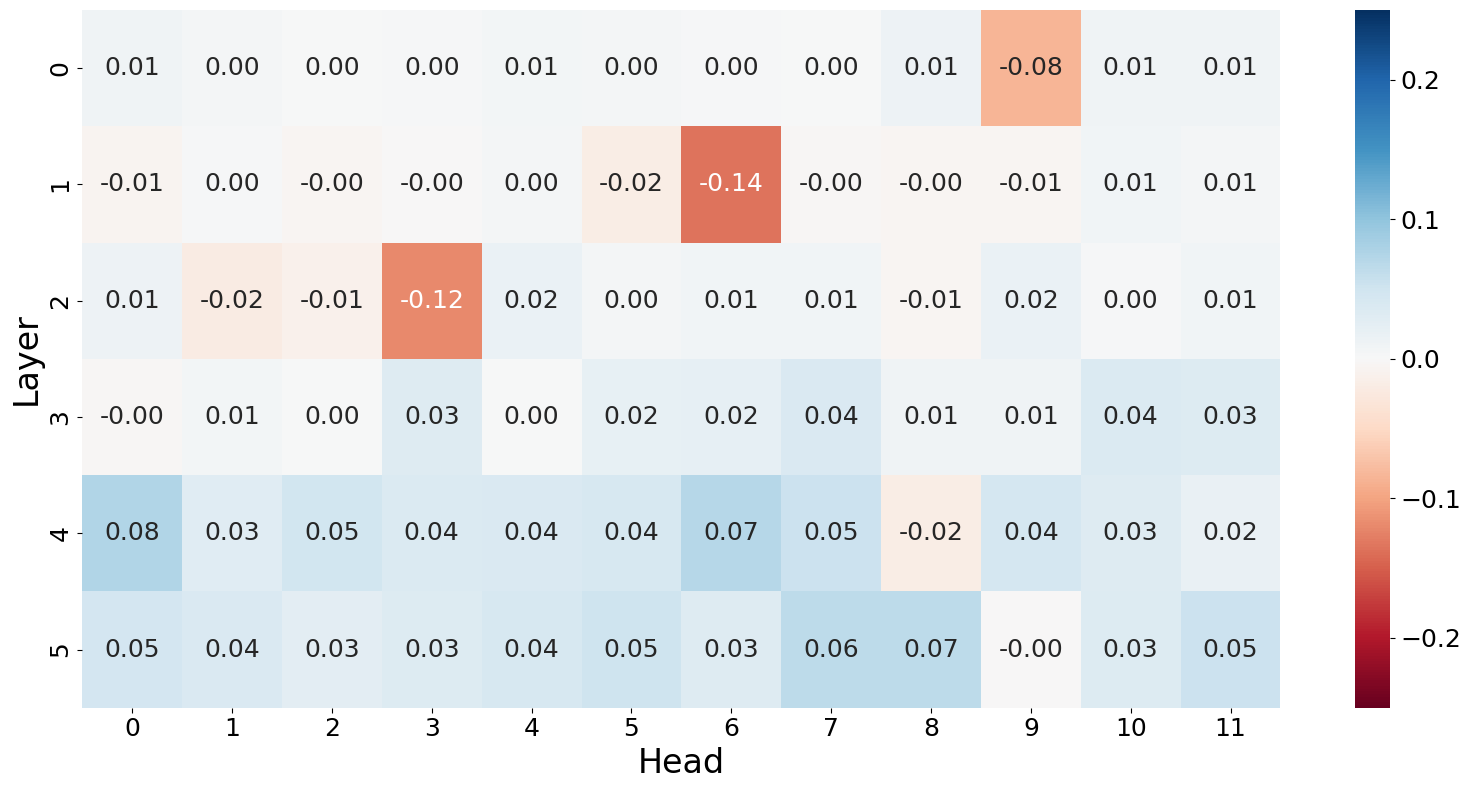

In [50]:
data_to_plot = patching_results_normalised.mean(axis=0)

plot(data_to_plot, 0.25, -0.25, figsize=(16, 8), title="")

Test how sorting by the IDF of the injected term alters the results

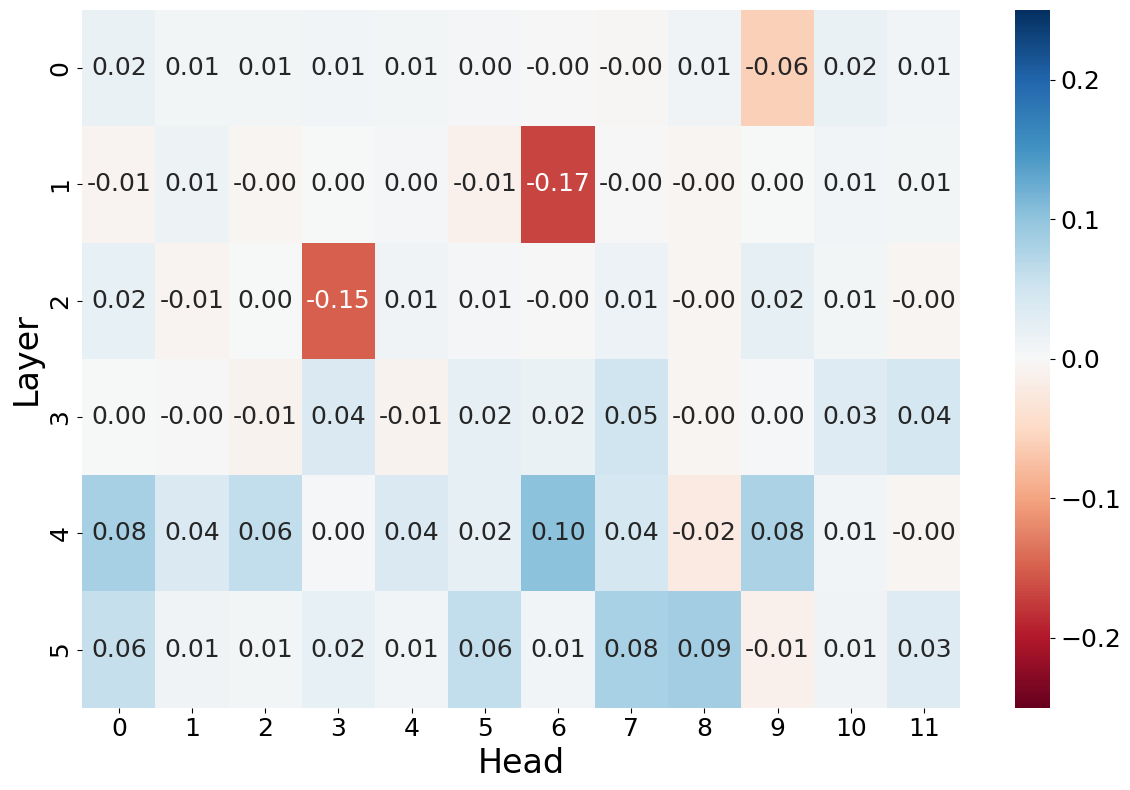

In [14]:
data_to_plot = patching_results_normalised[
    all_data_pd.sort_values(by='idf_injected_term', ascending=False).head(1000).index
].mean(axis=0)

plot(data_to_plot, 0.25, -0.25)

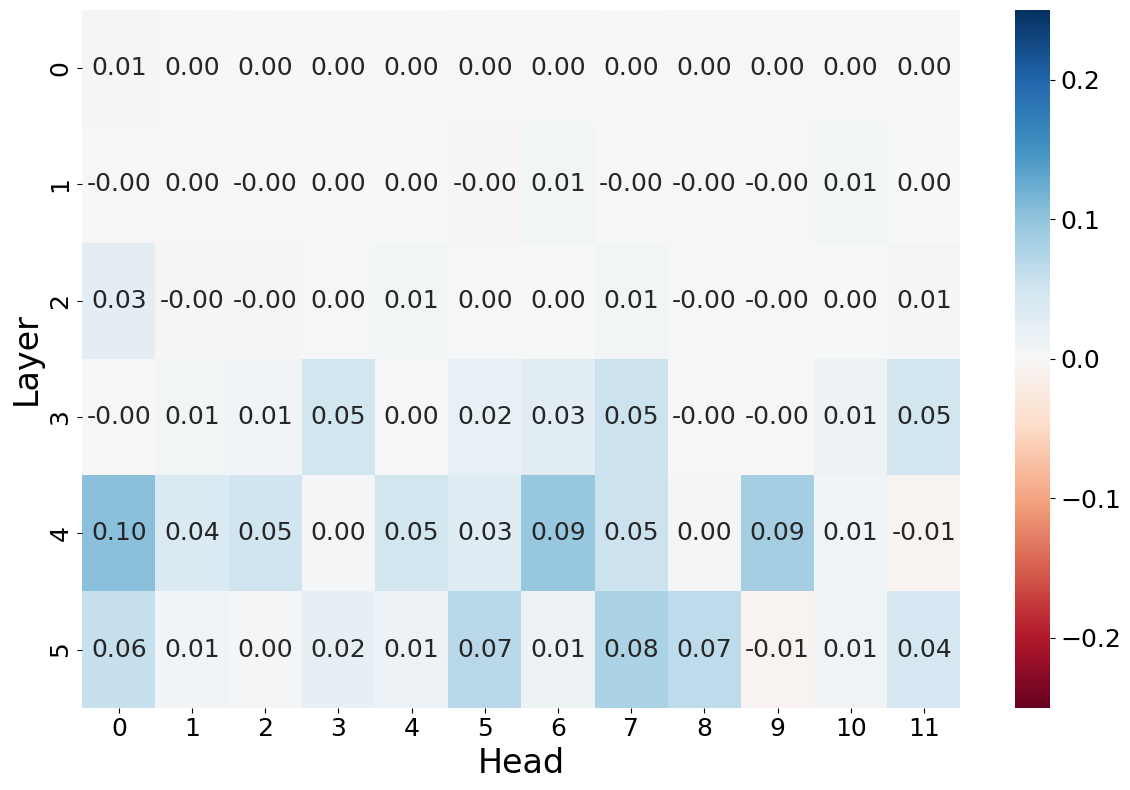

In [15]:
data_to_plot = patching_results_normalised[
    all_data_pd.sort_values(by='score_delta', ascending=False).head(1000).index
].mean(axis=0)

plot(data_to_plot, 0.25, -0.25)

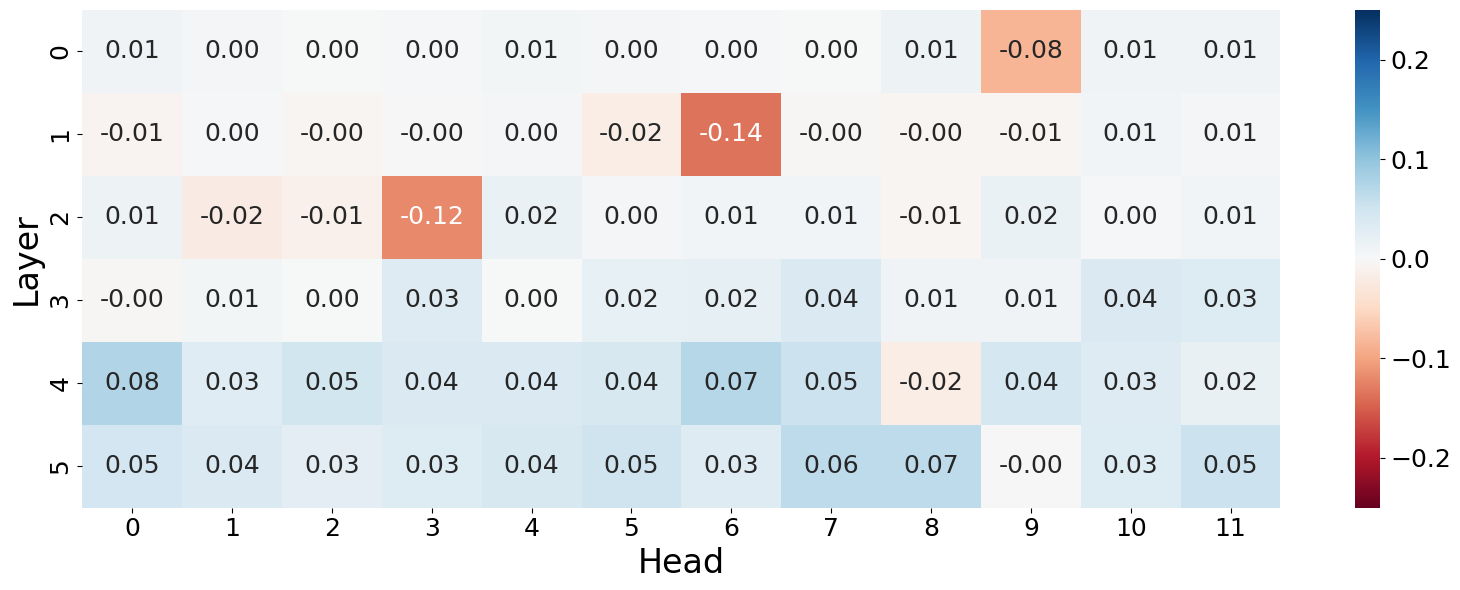

In [18]:
data_to_plot = patching_results_normalised[
    all_data_pd.sort_values(by='idf_injected_term', ascending=False).head(4000).index
].mean(axis=0)

# plot(data_to_plot, 0.25, -0.25, figsize=(16, 6), save_path='/mnt/qb/work/eickhoff/esx208/MechIR/notebooks/plots/head_patching_example.pdf')
plot(data_to_plot, 0.25, -0.25, figsize=(16, 6))

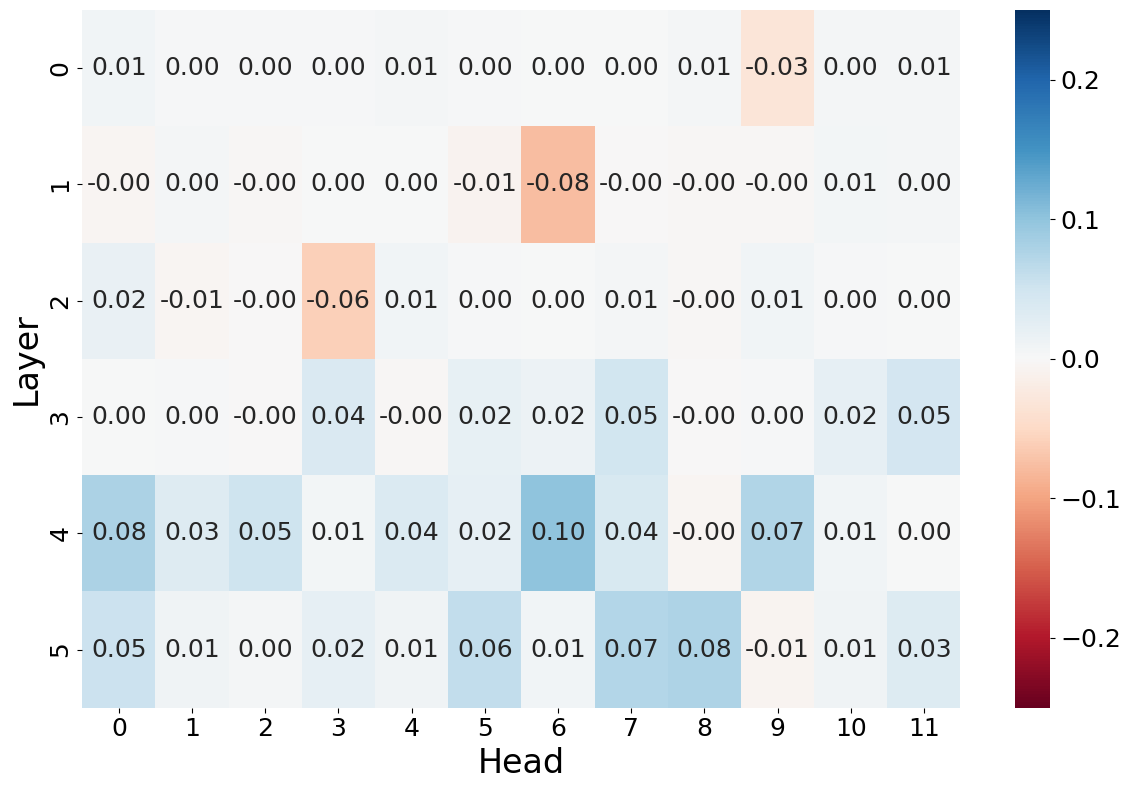

In [19]:
data_to_plot = patching_results_normalised_square[
    all_data_pd.sort_values(by='idf_injected_term', ascending=False).head(1000).index
].mean(axis=0)

plot(data_to_plot, 0.25, -0.25)

In [20]:
data_to_plot = patching_results_normalised_square[
    all_data_pd.sort_values(by='score_delta', ascending=False).head(4000).index
].mean(axis=0)

plot(data_to_plot, 0.25, -0.25, figsize=())

TypeError: from_bounds() missing 2 required positional arguments: 'width' and 'height'

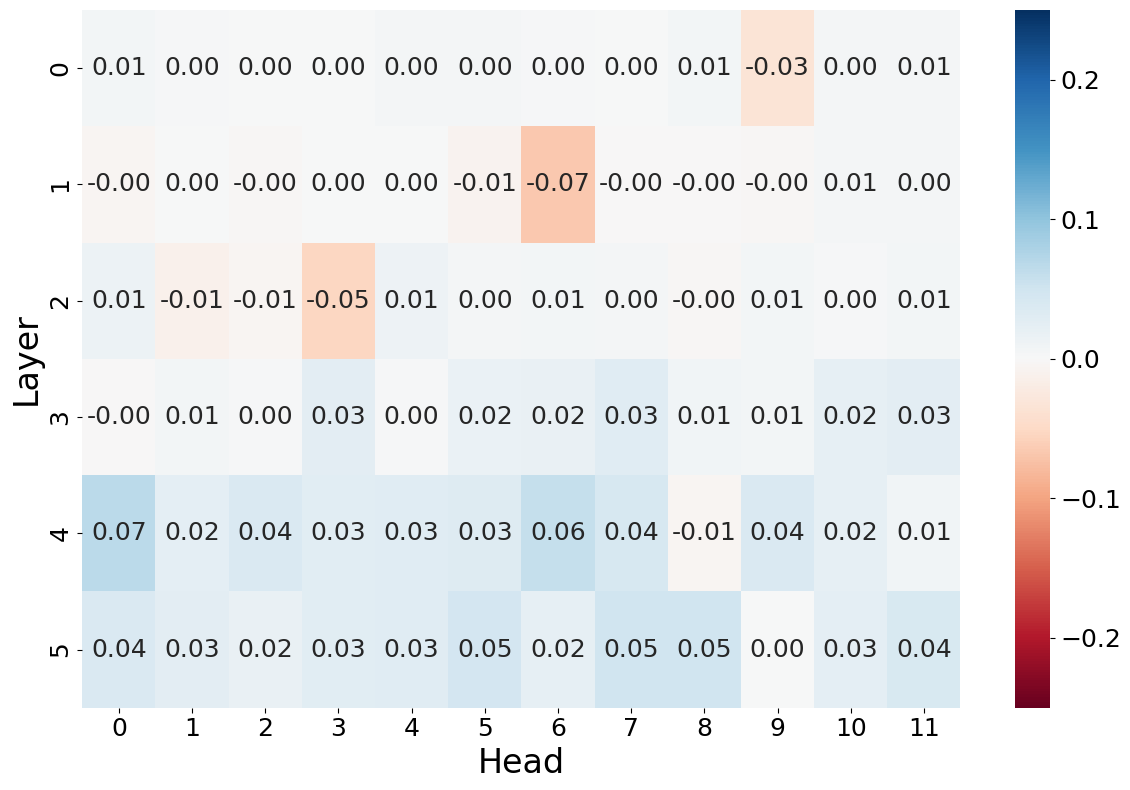

In [21]:
data_to_plot = patching_results_normalised_square[
    all_data_pd.sort_values(by='score_delta', ascending=False).head(4000).index
].mean(axis=0)

# plot(data_to_plot, 0.25, -0.25, None, save_path='/mnt/qb/work/eickhoff/esx208/MechIR/notebooks/plots/head_patching_example.pdf')
plot(data_to_plot, 0.25, -0.25, None)

Test how metric affects corner cases

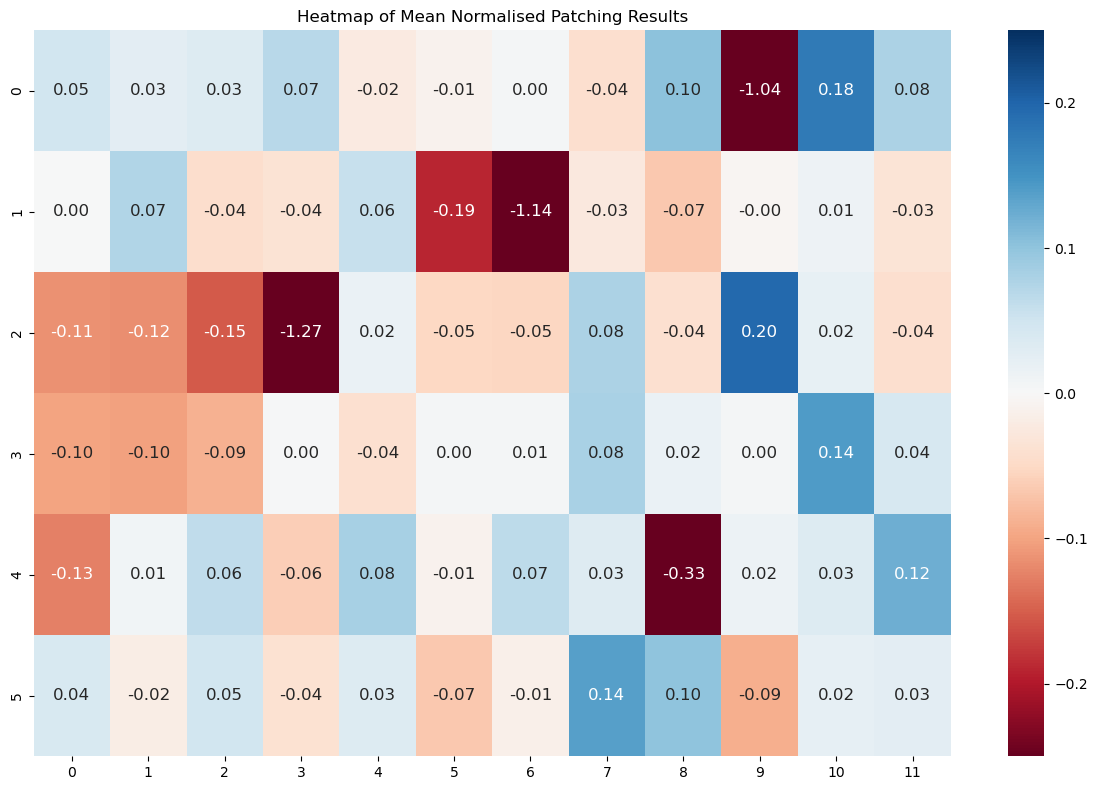

In [57]:
data_to_plot = patching_results_normalised[
    all_data_pd.sort_values(by='score_delta', ascending=True).head(100).index
].mean(axis=0)

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

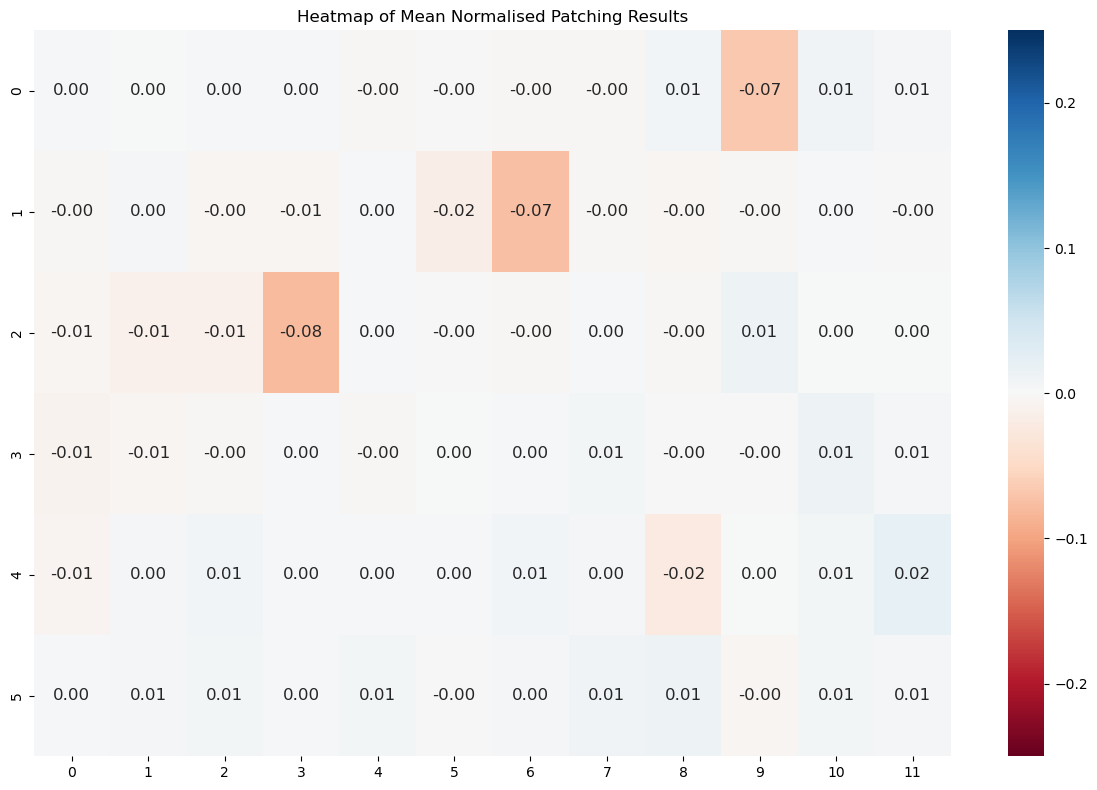

In [56]:
data_to_plot = patching_results_normalised_square[
    all_data_pd.sort_values(by='score_delta', ascending=True).head(100).index
].mean(axis=0)

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

/tmp/ipykernel_2442967/1257215539.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


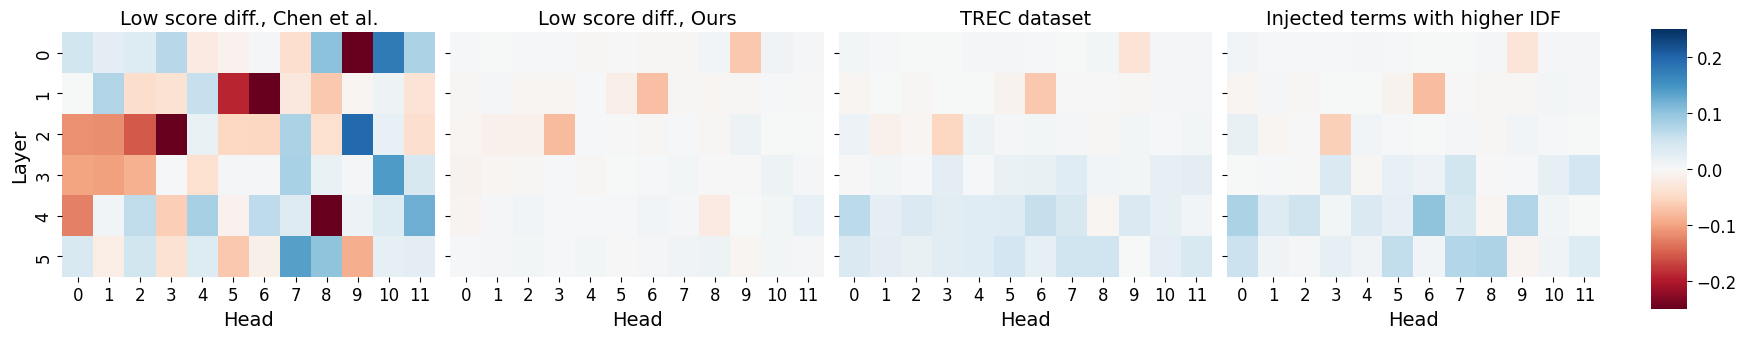

In [23]:
data_to_plot_0 = patching_results_normalised[
    all_data_pd.sort_values(by='score_delta', ascending=True).head(100).index
].mean(axis=0)

data_to_plot_1 = patching_results_normalised_square[
    all_data_pd.sort_values(by='score_delta', ascending=True).head(100).index
].mean(axis=0)

data_to_plot_2 = patching_results_normalised_square[
    all_data_pd.sort_values(by='score_delta', ascending=False).head(4000).index
].mean(axis=0)

data_to_plot_3 = patching_results_normalised_square[
    all_data_pd.sort_values(by='idf_injected_term', ascending=False).head(1000).index
].mean(axis=0)

save_path = './notebooks/plots/qualitative_results_poster.pdf'
titles = ['Low score diff., Chen et al.', 'Low score diff., Ours', 'TREC dataset', 'Injected terms with higher IDF']
plot_in_single_line([data_to_plot_0, data_to_plot_1, data_to_plot_2, data_to_plot_3], 0.25, -0.25, 
                    titles=titles, figsize=(18, 3.5), save_path=save_path, captions_fontsize=14)

/tmp/ipykernel_2442967/2955336269.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


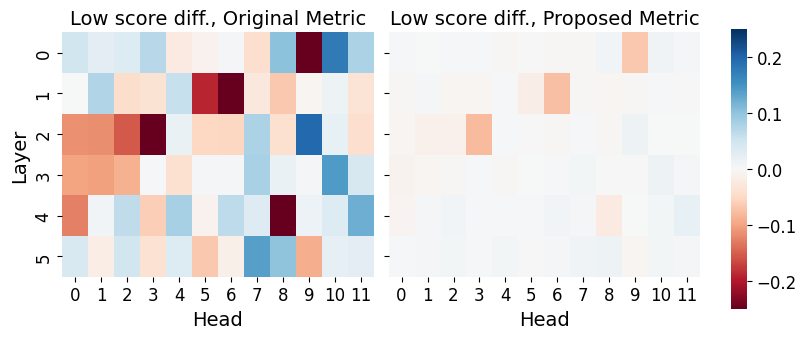

In [33]:
data_to_plot_0 = patching_results_normalised[
    all_data_pd.sort_values(by='score_delta', ascending=True).head(100).index
].mean(axis=0)

data_to_plot_1 = patching_results_normalised_square[
    all_data_pd.sort_values(by='score_delta', ascending=True).head(100).index
].mean(axis=0)

save_path = './notebooks/plots/qualitative_results_poster_metric.pdf'
titles = ['Low score diff., Original Metric', 'Low score diff., Proposed Metric']
plot_in_single_line([data_to_plot_0, data_to_plot_1], 0.25, -0.25, 
                    titles=titles, figsize=(8, 3.5), save_path=save_path, captions_fontsize=14)

/tmp/ipykernel_2442967/2955336269.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


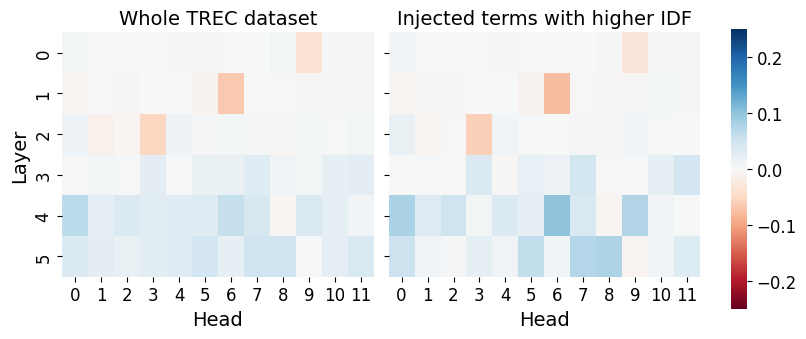

In [34]:
data_to_plot_2 = patching_results_normalised_square[
    all_data_pd.sort_values(by='score_delta', ascending=False).head(4000).index
].mean(axis=0)

data_to_plot_3 = patching_results_normalised_square[
    all_data_pd.sort_values(by='idf_injected_term', ascending=False).head(1000).index
].mean(axis=0)

save_path = './notebooks/plots/qualitative_results_poster_dataset.pdf'
titles = ['Whole TREC dataset', 'Injected terms with higher IDF']
plot_in_single_line([data_to_plot_2, data_to_plot_3], 0.25, -0.25, 
                    titles=titles, figsize=(8, 3.5), save_path=save_path, captions_fontsize=14)

/scratch_local/esx208-1151548/tmp/ipykernel_2994998/1515722974.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


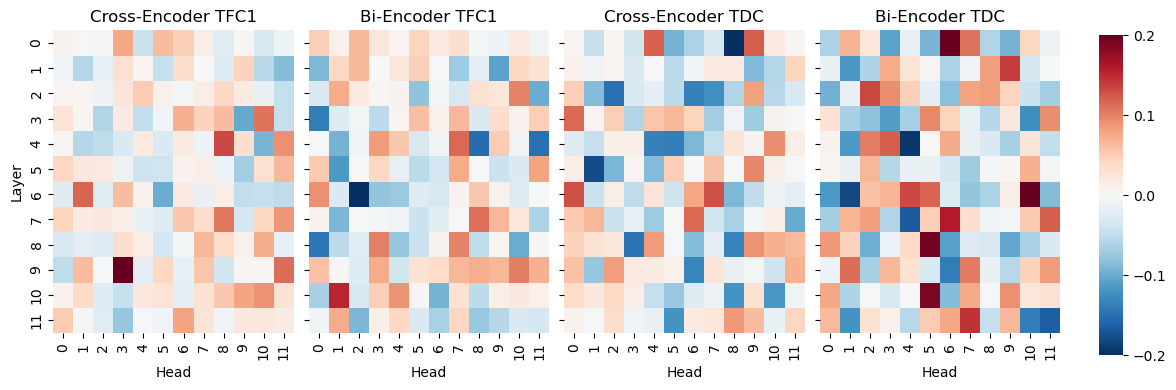

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Replace these with your actual NumPy arrays
data1 = np.random.randn(12, 12) * 0.1  # Cross-Encoder TFC1
data2 = np.random.randn(12, 12) * 0.1  # Bi-Encoder TFC1
data3 = np.random.randn(12, 12) * 0.1  # Cross-Encoder TDC
data4 = np.random.randn(12, 12) * 0.1  # Bi-Encoder TDC

data_arrays = [data1, data2, data3, data4]
titles = ["Cross-Encoder TFC1", "Bi-Encoder TFC1", "Cross-Encoder TDC", "Bi-Encoder TDC"]

fig, axes = plt.subplots(1, 4, figsize=(12, 4), sharex=True, sharey=True)
cmap = "RdBu_r"  # Blue-Red diverging colormap

for i, (ax, data, title) in enumerate(zip(axes, data_arrays, titles)):
    sns.heatmap(data, ax=ax, cmap=cmap, center=0, cbar=False, yticklabels=True)
    ax.set_title(title)
    ax.set_xlabel("Head")
    if i == 0:
        ax.set_ylabel("Layer")
    else:
        ax.set_ylabel("")

# Add a single colorbar for the entire height
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
norm = plt.Normalize(-0.2, 0.2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical', ticks=[-0.2, -0.1, 0, 0.1, 0.2])
cbar.outline.set_visible(False)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

Importance of queries over documents

Let's take a single query and try to vary documents

In [60]:
all_data_pd['query'].unique()

array(['what is mamey', 'what is theraderm used for', 'define etruscans',
       'what carvedilol used for', 'definition of a sigmet',
       'define visceral?', 'how is the weather in jamaica',
       'what is a nonconformity? earth science',
       'what is physical description of spruce',
       'where is the show shameless filmed', 'define bmt medical',
       'exons definition biology', 'what is famvir prescribed for',
       'what is a alm', 'do goldfish grow', 'is caffeine an narcotic',
       'rsa definition key', 'who is aziz hashim',
       'definition declaratory judgment', 'who is rep scalise?',
       'what is chaff and flare', 'what is wifi vs bluetooth',
       'what are the three percenters?', 'define: geon',
       'lps laws definition', 'what is the un fao', 'meaning of shebang',
       'example of monotonic function',
       'does legionella pneumophila cause pneumonia',
       'what is the most popular food in switzerland',
       'what is an aml surveillance analys

In [68]:
random_queries = random.sample(all_data_pd['query'].unique().tolist(), 5)
data_random_5_queries = all_data_pd[all_data_pd['query'].isin(random_queries)]

In [66]:
all_data_pd[all_data_pd['query'].isin(random_queries)]

['what metal are hip replacements made of',
 'do goldfish grow',
 'what carvedilol used for',
 'describe how muscles and bones work together to produce movement',
 'how long is life cycle of flea']

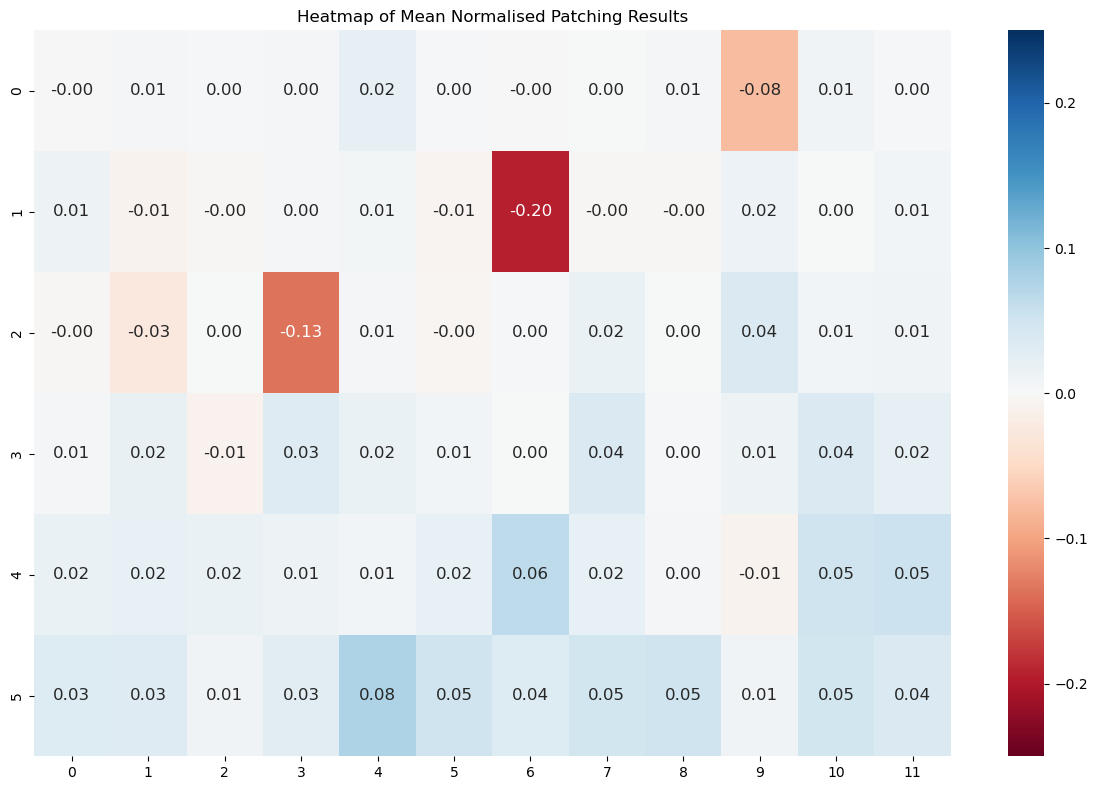

In [69]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[all_data_pd['query'] == random_queries[0]].index
].mean(axis=0)

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

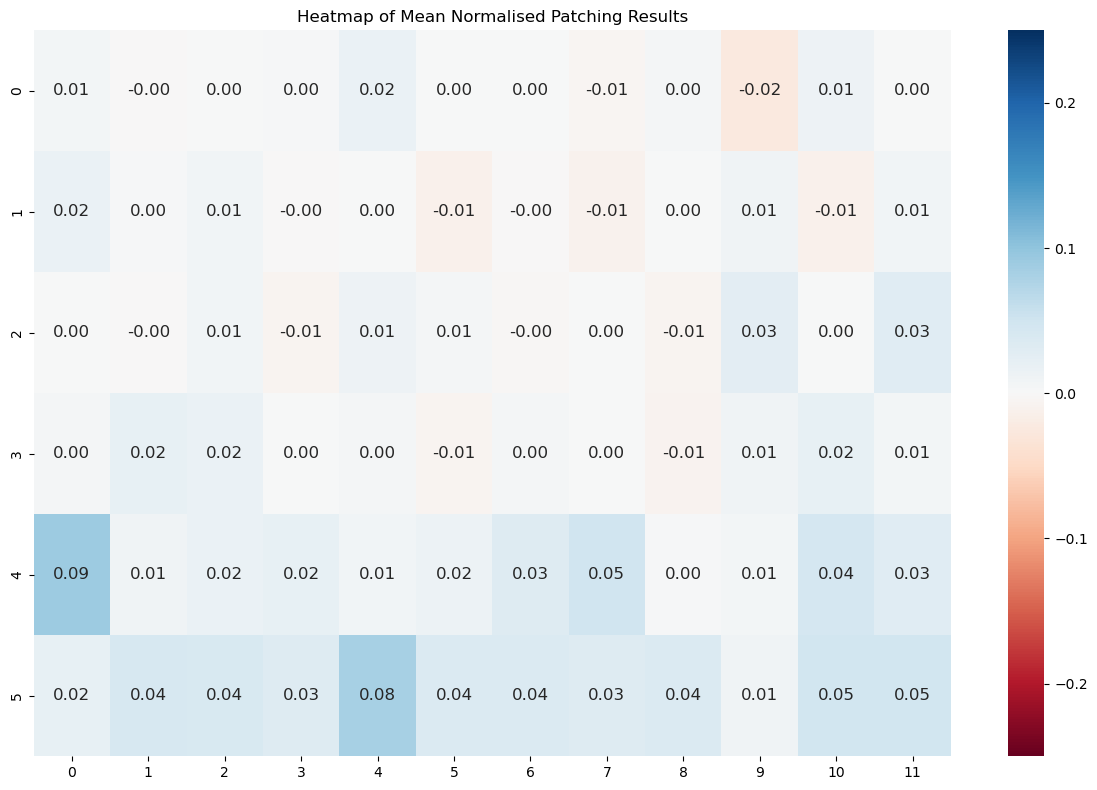

In [70]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[all_data_pd['query'] == random_queries[1]].index
].mean(axis=0)

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

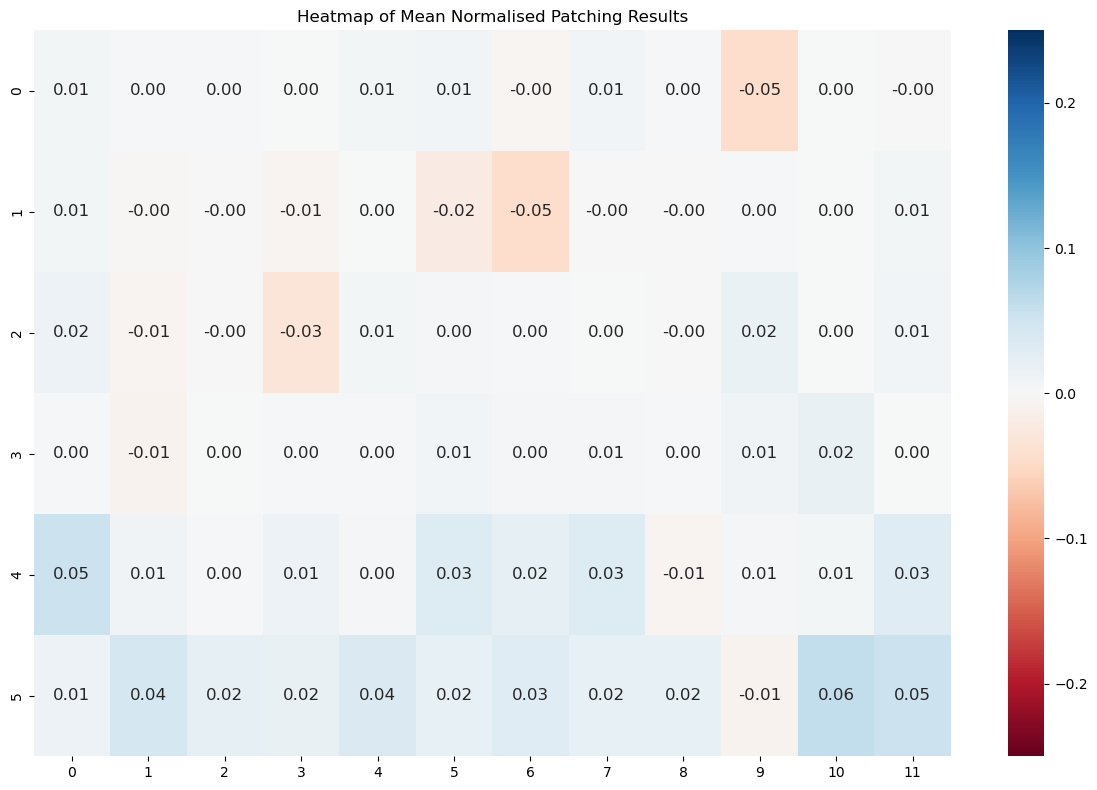

In [71]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[all_data_pd['query'] == random_queries[2]].index
].mean(axis=0)

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

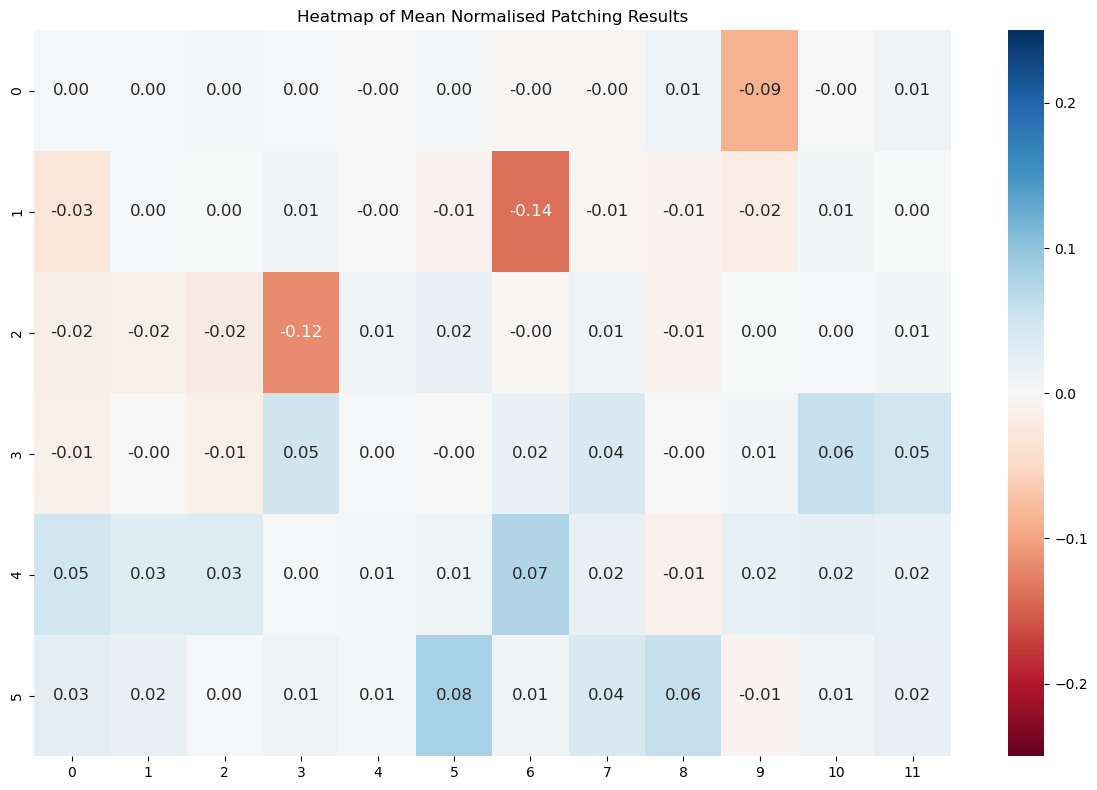

In [72]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[all_data_pd['query'] == random_queries[3]].index
].mean(axis=0)

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

Let's take a single query and vary documents

In [87]:
all_data_pd[all_data_pd['query'] == random_queries[0]]

,qid,query,docno,text,relevance,perturbed,perturbed_score,rank,original_score,score_delta,...,tfidf_injected_term,injected_term_token_len,patching_effect_std,patching_effect_absolute_mean,patching_effect_normalised_std,patching_effect_normalised_absolute_mean,patching_effect_normalised_square_std,patching_effect_normalised_square_absolute_mean,patching_effect_normalised_clip_std,patching_effect_normalised_clip_absolute_mean
1569,1121402,what can contour plowing reduce,5576063,"After the dust bowl, the government encouraged...",1,True,94.320915,113,92.581474,1.739441,...,0.197333,2,0.110158,0.065582,0.063329,0.037703,0.054903,0.032686,0.063329,0.037703
1591,1121402,what can contour plowing reduce,4449258,a) Plow fields along contour lines. b) Leave p...,1,True,95.843124,95,93.986313,1.856812,...,0.000000,2,0.064844,0.053289,0.034922,0.028699,0.030747,0.025268,0.034922,0.028699
1844,1121402,what can contour plowing reduce,182371,"If your problem is in your fields, and you do ...",1,True,100.748230,56,99.544601,1.203629,...,0.134844,2,0.102549,0.053763,0.085200,0.044667,0.065533,0.034357,0.085200,0.044667
2241,1121402,what can contour plowing reduce,4449267,Best Answer: 5) Which is the best way to preve...,2,True,97.759758,84,95.716789,2.042969,...,0.175884,2,0.074222,0.055478,0.036331,0.027156,0.032631,0.024390,0.036331,0.027156
2244,1121402,what can contour plowing reduce,182367,"For prevention of rain-driven erosion, it is i...",2,True,102.846062,31,100.943703,1.902359,...,0.161813,2,0.102102,0.068523,0.053671,0.036020,0.047507,0.031883,0.053671,0.036020
2609,1121402,what can contour plowing reduce,182369,Contour plowing Contour ploughing or contour f...,2,True,106.511368,2,105.494041,1.017326,...,0.000000,1,0.048314,0.025164,0.047491,0.024736,0.033869,0.017640,0.047491,0.024736
2647,1121402,what can contour plowing reduce,182372,Contour plowing. Contour ploughing or contour ...,2,True,106.076897,6,105.146675,0.930222,...,0.000000,1,0.045532,0.023842,0.048947,0.025631,0.033338,0.017457,0.048947,0.025631
2688,1121402,what can contour plowing reduce,8052620,2016-09-28T08:13:26-04:00. Farmers can reduce ...,2,True,107.059624,0,106.070595,0.989029,...,0.141942,2,0.181939,0.067873,0.183957,0.068626,0.129358,0.048257,0.174484,0.067000
2765,1121402,what can contour plowing reduce,8052617,Both contour plowing and terrace farming are s...,2,True,103.882957,22,102.899765,0.983192,...,0.134844,2,0.043896,0.033057,0.044646,0.033623,0.031301,0.023572,0.044646,0.033623
2854,1121402,what can contour plowing reduce,6001847,2. Use terrace farming. This type of farming u...,2,True,98.188904,82,97.397003,0.791901,...,0.283883,2,0.056865,0.031042,0.071808,0.039199,0.044580,0.024336,0.071808,0.039199


In [92]:
all_data_pd[all_data_pd['query'] == random_queries[0]].index

Index([1569, 1591, 1844, 2241, 2244, 2609, 2647, 2688, 2765, 2854, 2960], dtype='int64')

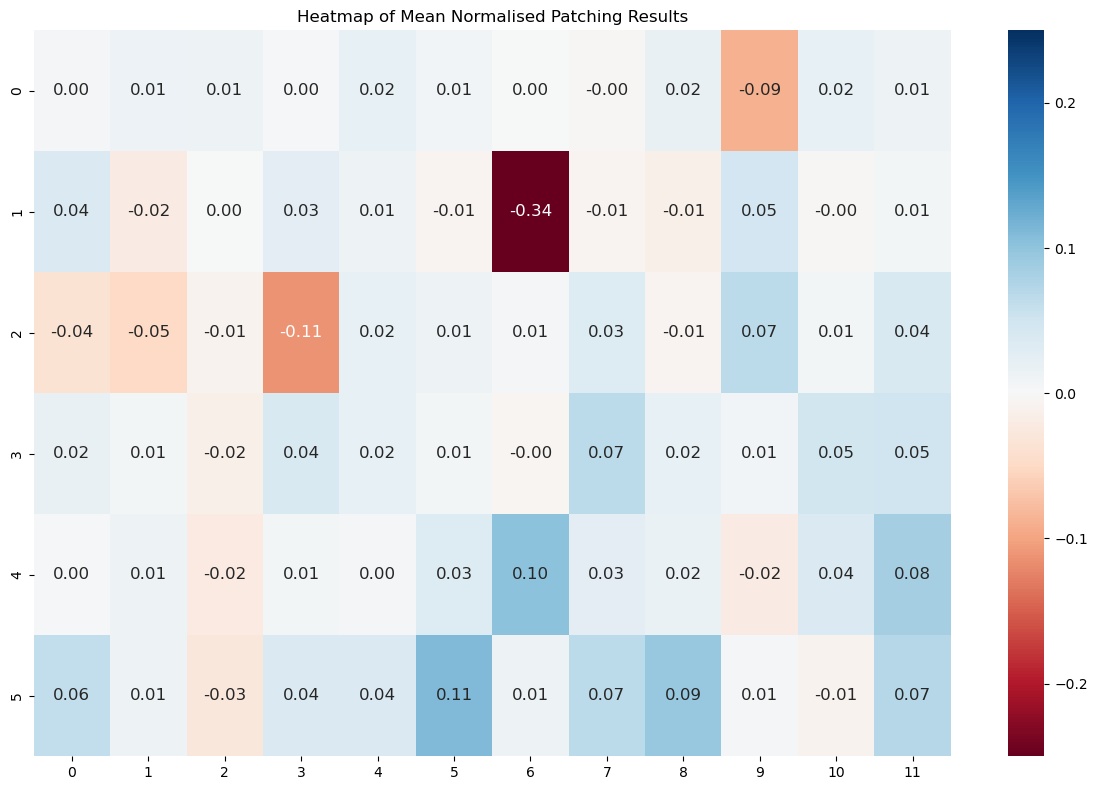

In [84]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[all_data_pd['query'] == random_queries[0]].index[0]
]

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

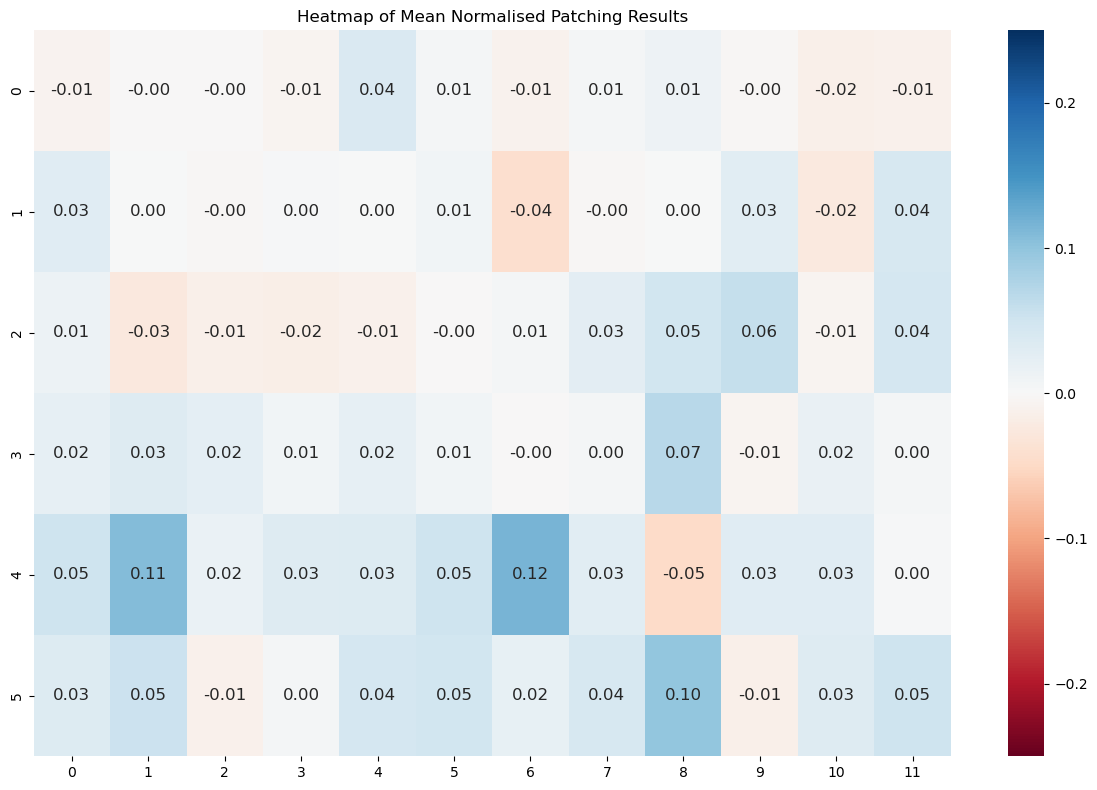

In [85]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[all_data_pd['query'] == random_queries[0]].index[1]
]

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

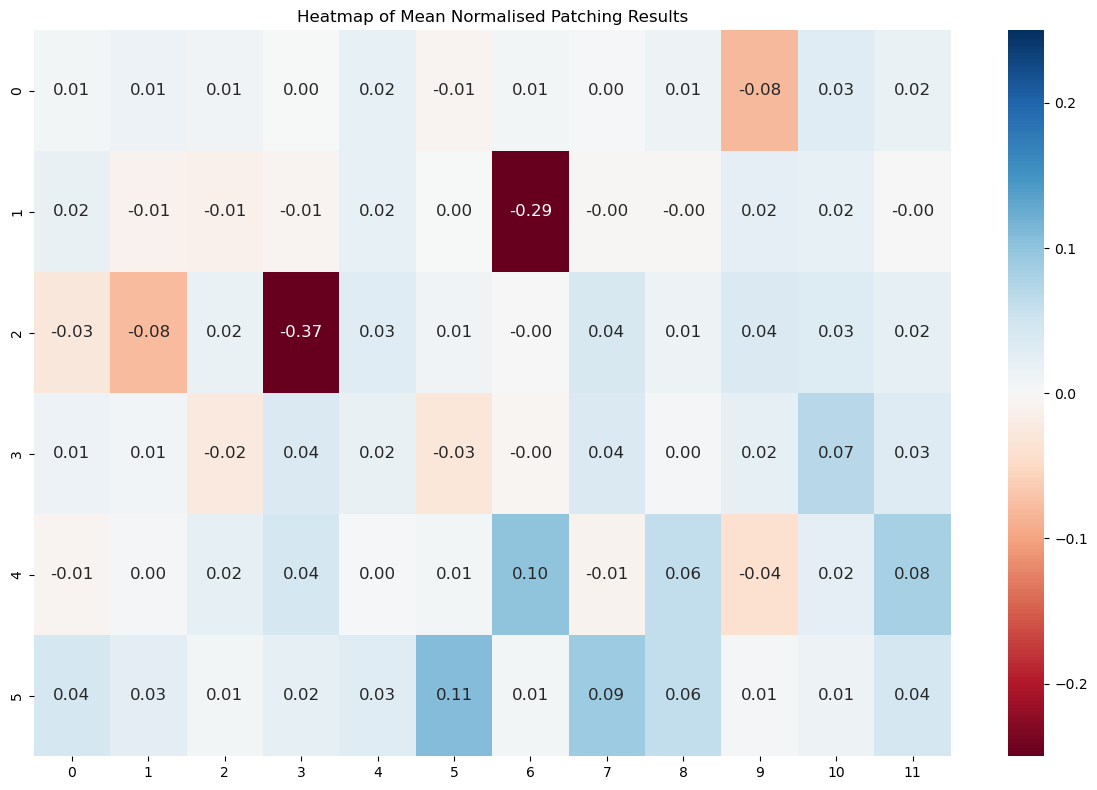

In [86]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[all_data_pd['query'] == random_queries[0]].index[2]
]

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

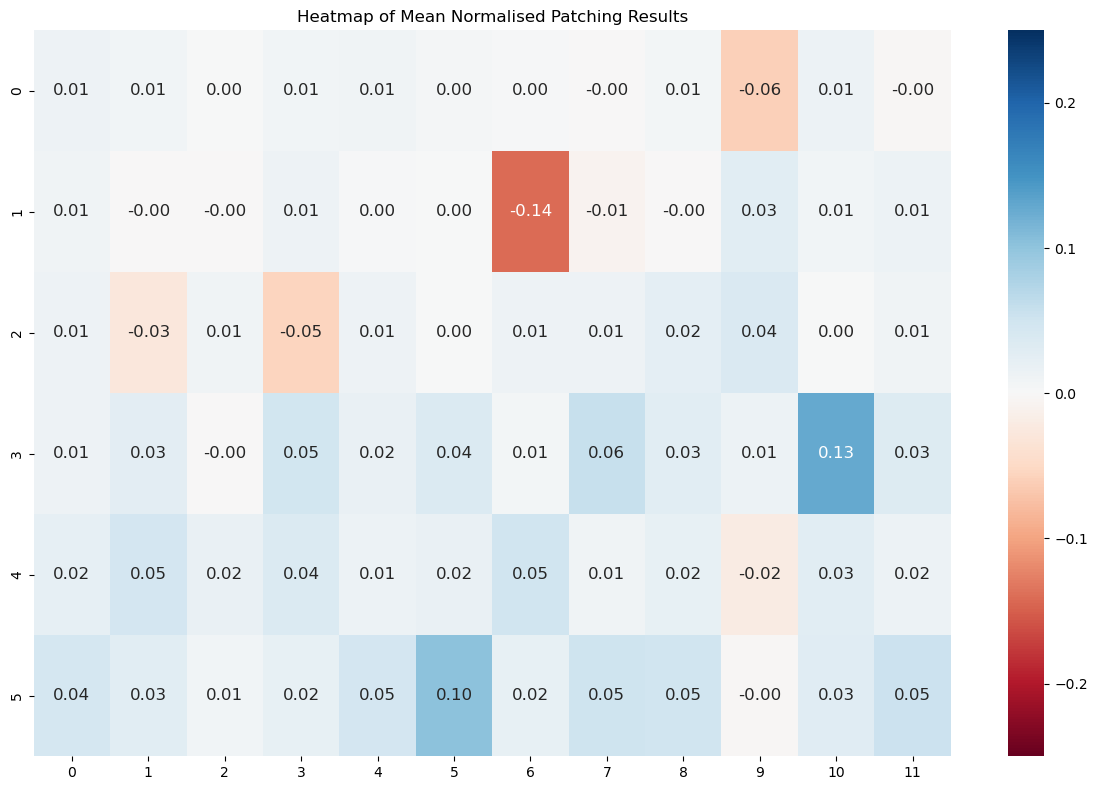

In [90]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[all_data_pd['query'] == random_queries[0]].index[3]
]

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

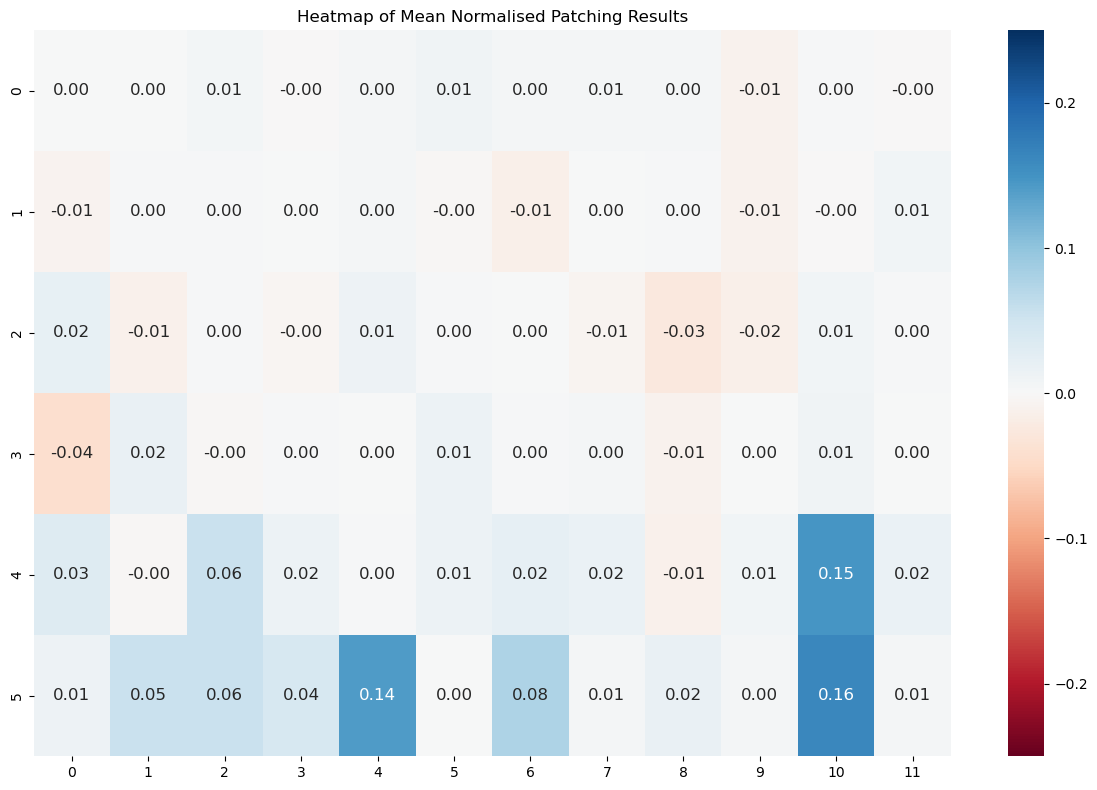

In [89]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[all_data_pd['query'] == random_queries[0]].index[5]
]

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

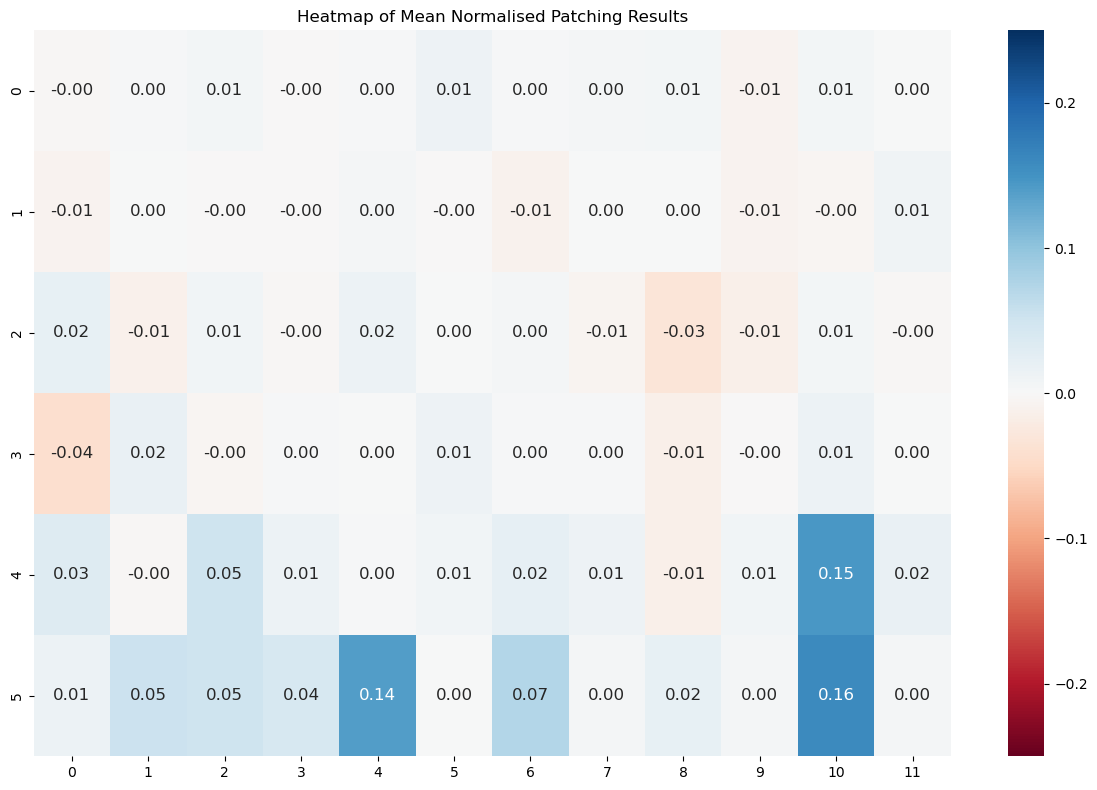

In [88]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[all_data_pd['query'] == random_queries[0]].index[6]
]

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

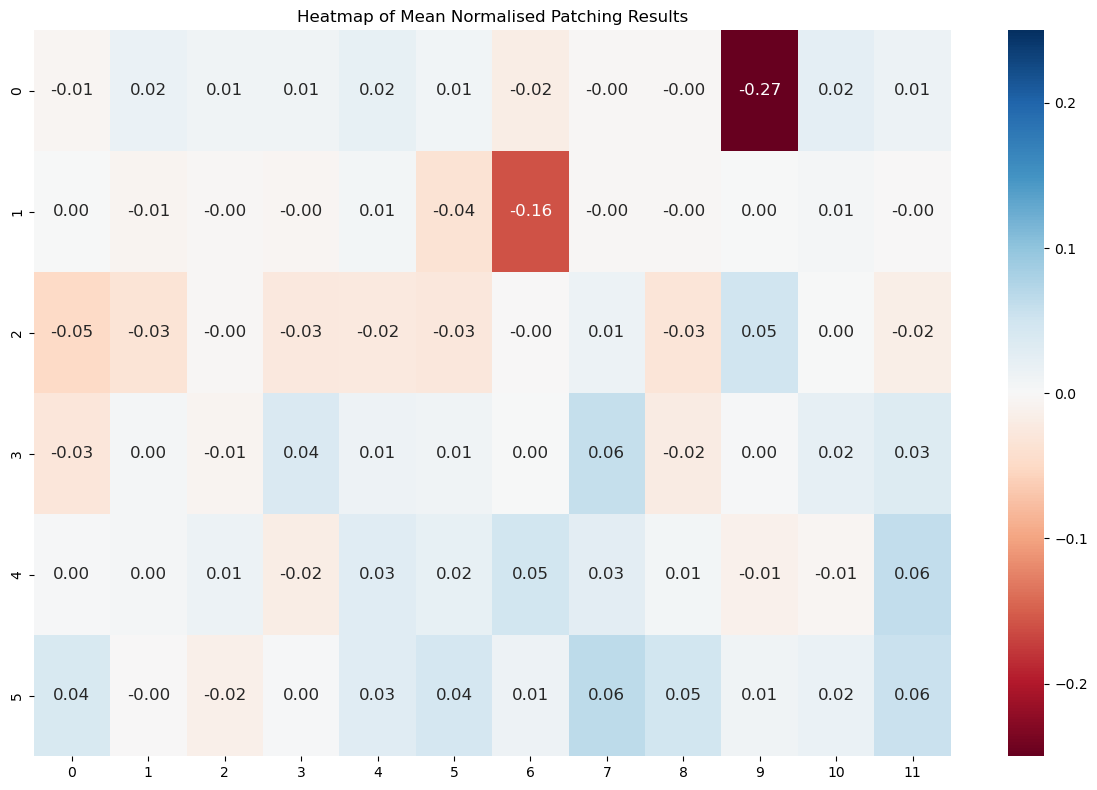

In [93]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[all_data_pd['query'] == random_queries[0]].index[-2]
]

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

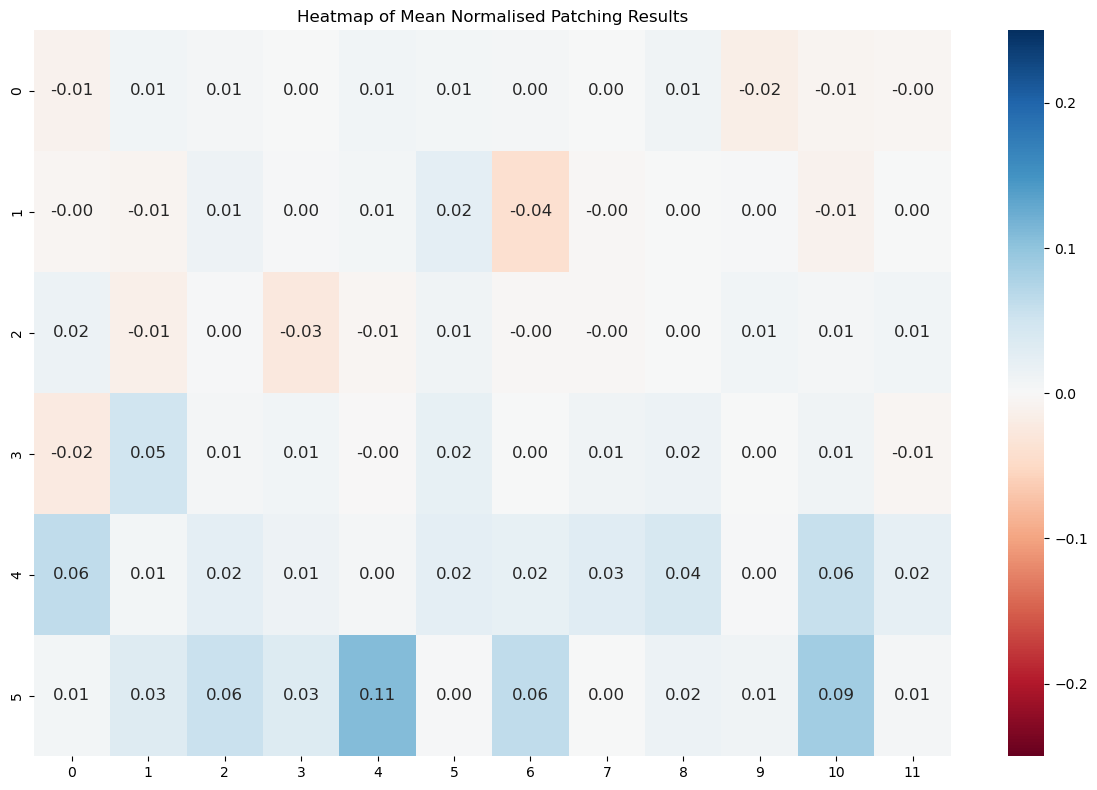

In [91]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[all_data_pd['query'] == random_queries[0]].index[-1]
]

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

Let's test another query

In [101]:
all_data_pd[all_data_pd['query'] == random_queries[2]]

,qid,query,docno,text,relevance,perturbed,perturbed_score,rank,original_score,score_delta,...,tfidf_injected_term,injected_term_token_len,patching_effect_std,patching_effect_absolute_mean,patching_effect_normalised_std,patching_effect_normalised_absolute_mean,patching_effect_normalised_square_std,patching_effect_normalised_square_absolute_mean,patching_effect_normalised_clip_std,patching_effect_normalised_clip_absolute_mean
807,47210,average wedding dress alteration cost,8703469,Angle Bracket. Owing to our rich industrial ex...,0,True,91.618828,291,85.280098,6.338730,...,0.000000,1,0.291401,0.153107,0.045972,0.024154,0.045410,0.023859,0.045972,0.024154
1910,47210,average wedding dress alteration cost,2546003,1 Sleeve alterations usually run between $40 a...,1,True,102.435982,180,101.399422,1.036560,...,0.000000,1,0.040596,0.027015,0.039164,0.026062,0.028186,0.018757,0.039164,0.026062
1987,47210,average wedding dress alteration cost,4748997,According to wedding statistics released in 20...,1,True,107.015907,43,106.115120,0.900787,...,0.000000,1,0.038334,0.026783,0.042557,0.029732,0.028483,0.019900,0.042557,0.029732
2767,47210,average wedding dress alteration cost,7509250,1 The cups (if you aren’t wearing a bra) – $20...,2,True,101.809402,191,101.008553,0.800850,...,0.000000,1,0.036073,0.023360,0.045044,0.029169,0.028157,0.018234,0.045044,0.029169
2919,47210,average wedding dress alteration cost,1880177,"1 Complex alterations, such as bringing the dr...",2,True,105.698875,94,105.120224,0.578651,...,0.000000,1,0.028973,0.018817,0.050069,0.032519,0.025077,0.016287,0.050069,0.032519
3769,47210,average wedding dress alteration cost,2545998,"$219. In 2015, the average cost of a wedding d...",3,True,112.081314,7,111.801933,0.279381,...,0.226972,1,0.020108,0.013903,0.071974,0.049764,0.019366,0.013390,0.071974,0.049764
3782,47210,average wedding dress alteration cost,2546005,"In 2015, the average cost of a wedding dress a...",3,True,112.582924,4,112.303230,0.279694,...,0.239299,1,0.025254,0.018077,0.090292,0.064632,0.024321,0.017409,0.090292,0.064632
3795,47210,average wedding dress alteration cost,3304362,Common Wedding Gown Alterations and Cost: 1 T...,3,True,107.462311,37,107.176857,0.285454,...,0.105661,1,0.017113,0.012744,0.059952,0.044645,0.016456,0.012255,0.059952,0.044645
3905,47210,average wedding dress alteration cost,2546007,- Bridal shops offering alteration services ar...,3,True,111.640900,10,111.449631,0.191269,...,0.184907,1,0.036945,0.020299,0.193156,0.106130,0.036287,0.019938,0.178551,0.103668
3918,47210,average wedding dress alteration cost,2042918,- Bridal shops offering alteration services ar...,3,True,111.473167,12,111.354469,0.118698,...,0.174030,1,0.011085,0.006953,0.093385,0.058581,0.011007,0.006905,0.093385,0.058581


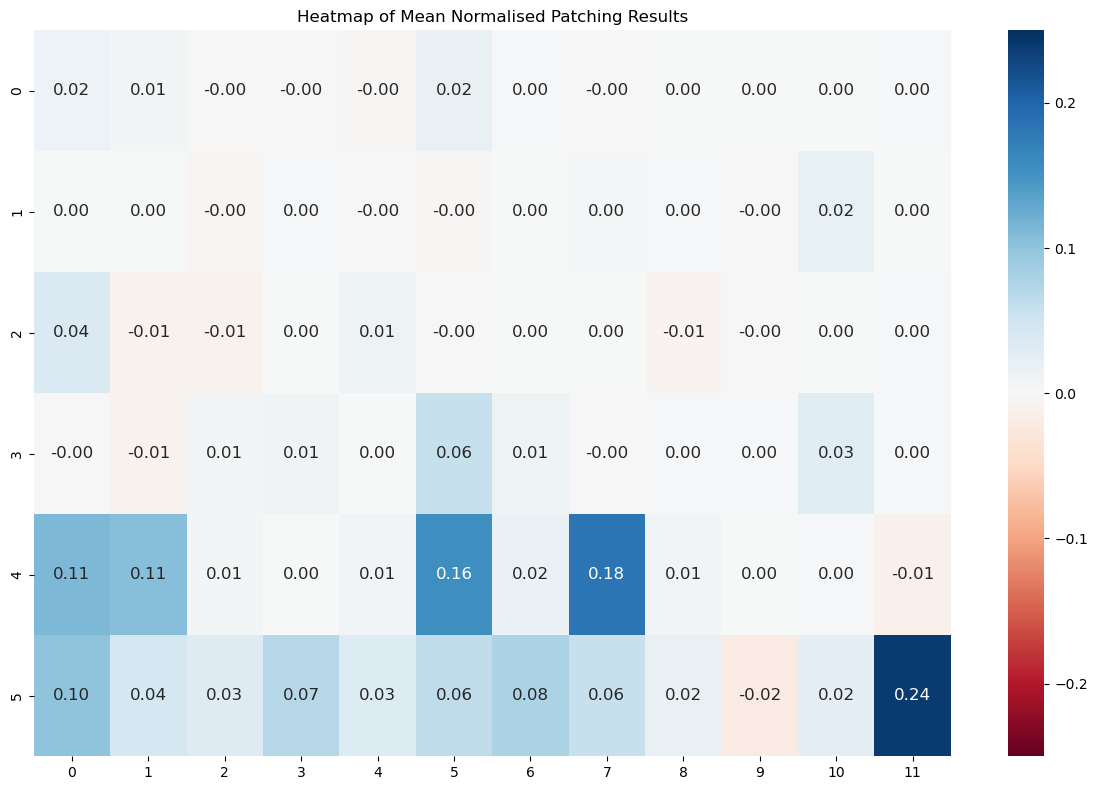

In [99]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[(all_data_pd['query'] == random_queries[2]) & (all_data_pd['injected_term'] == 'dress')].index[0]
]

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

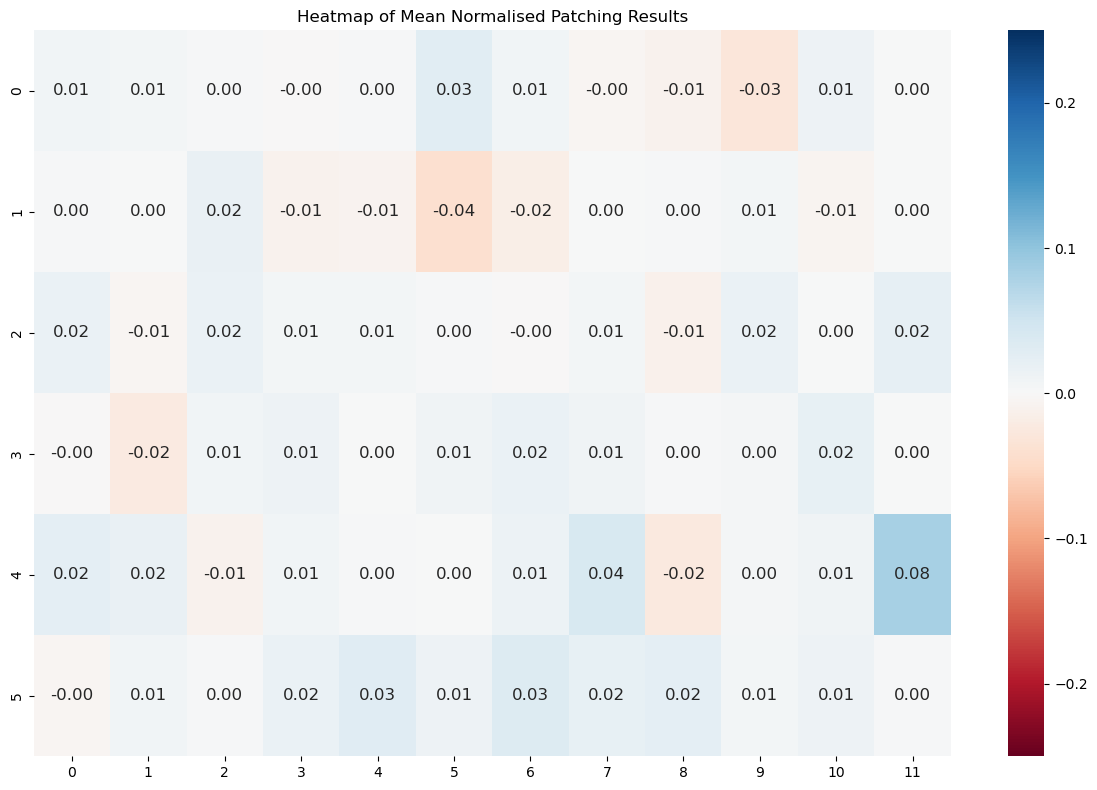

In [102]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[(all_data_pd['query'] == random_queries[2]) & (all_data_pd['injected_term'] == 'dress')].index[1]
]

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

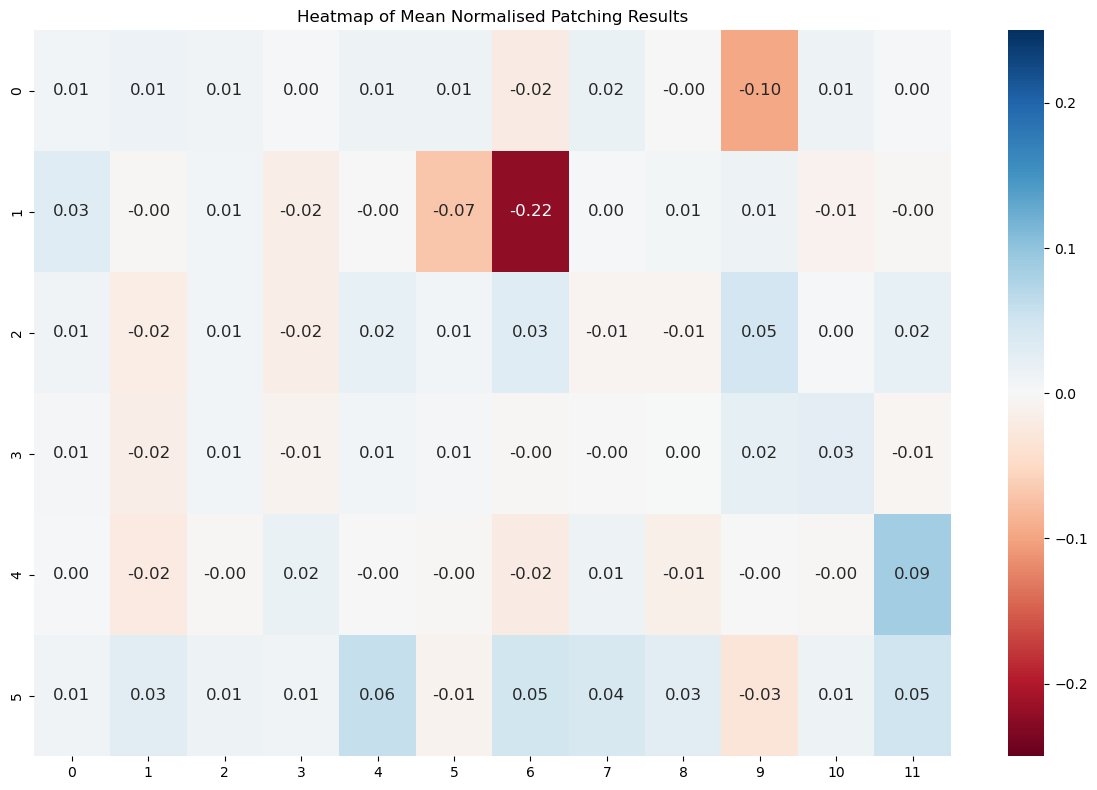

In [103]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[(all_data_pd['query'] == random_queries[2]) & (all_data_pd['injected_term'] == 'dress')].index[2]
]

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

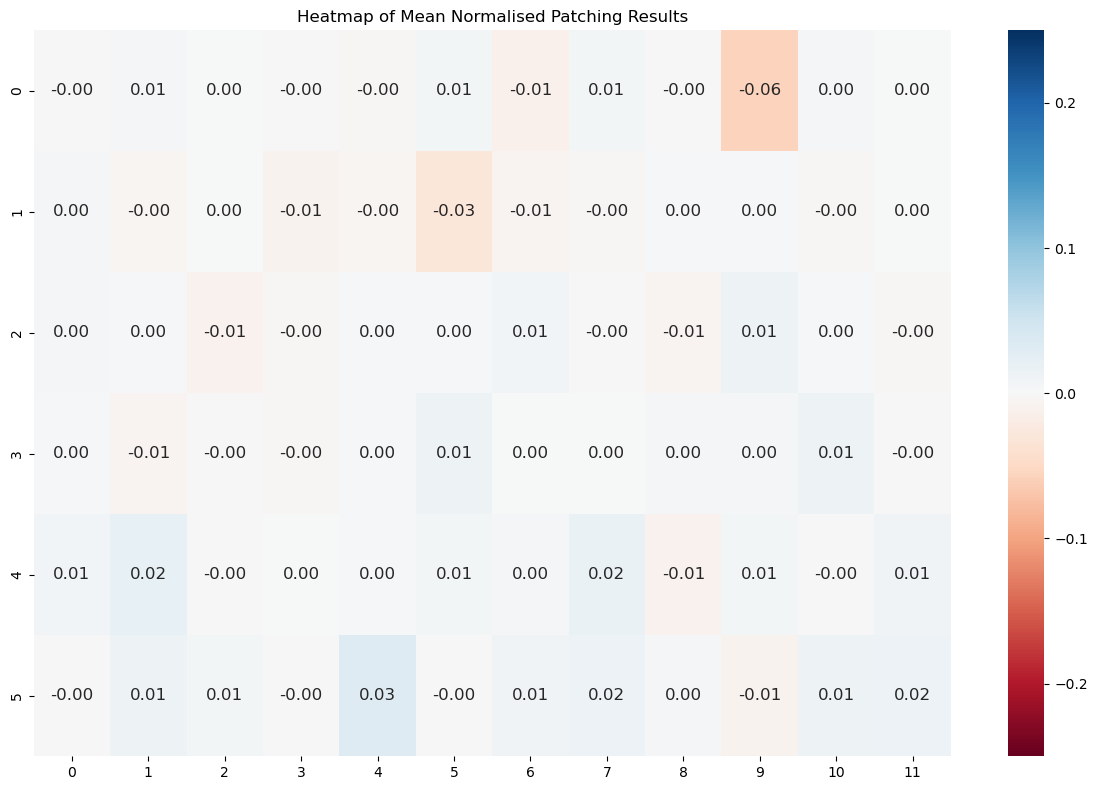

In [104]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[(all_data_pd['query'] == random_queries[2]) & (all_data_pd['injected_term'] == 'dress')].index[3]
]

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

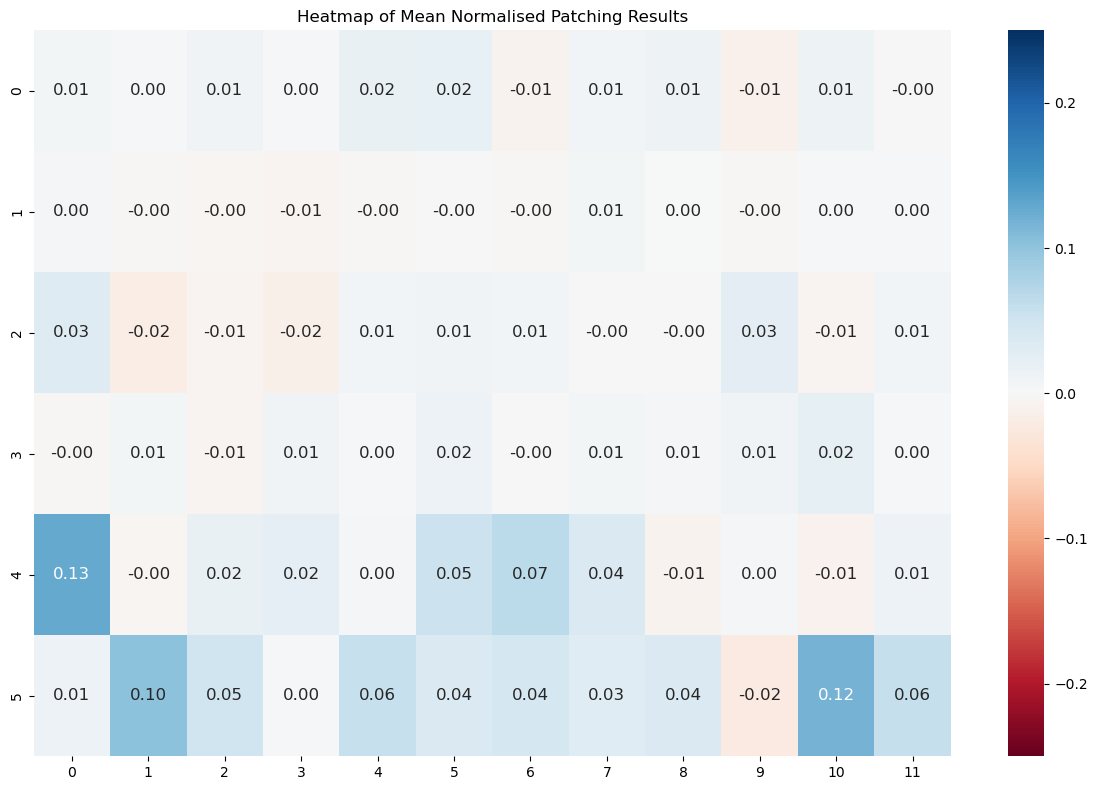

In [105]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[(all_data_pd['query'] == random_queries[2]) & (all_data_pd['injected_term'] == 'alteration')].index[0]
]

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

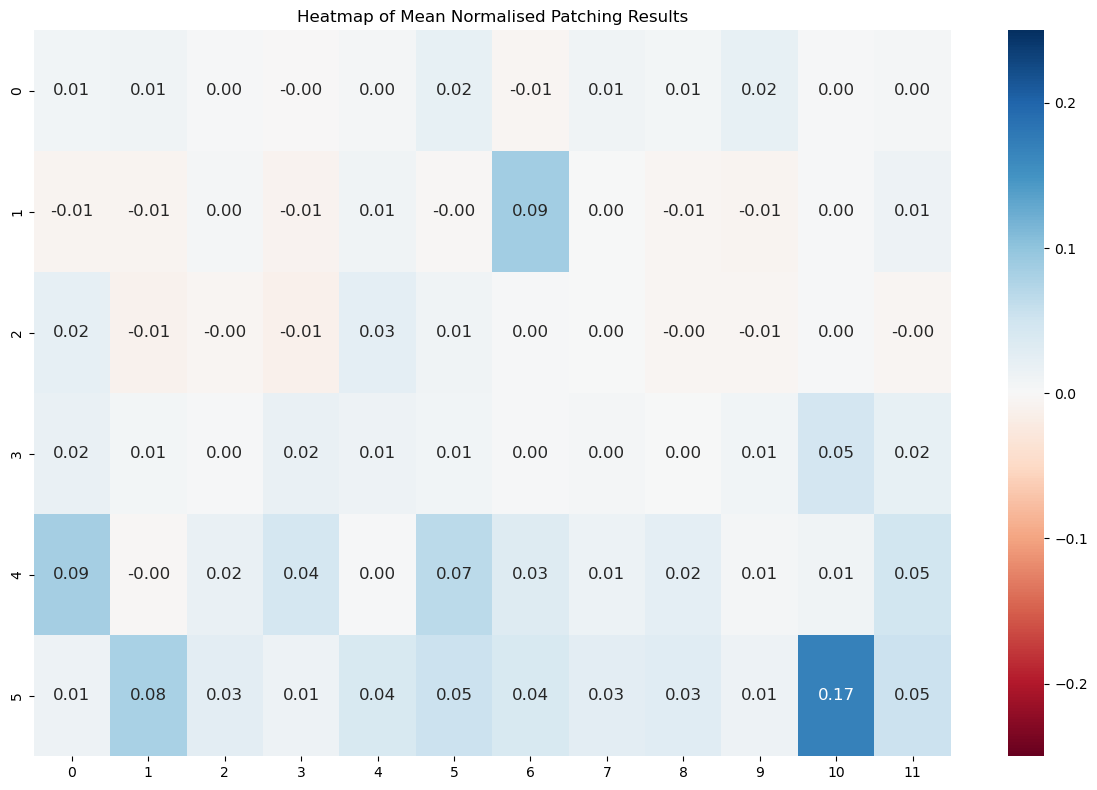

In [106]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[(all_data_pd['query'] == random_queries[2]) & (all_data_pd['injected_term'] == 'alteration')].index[1]
]

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

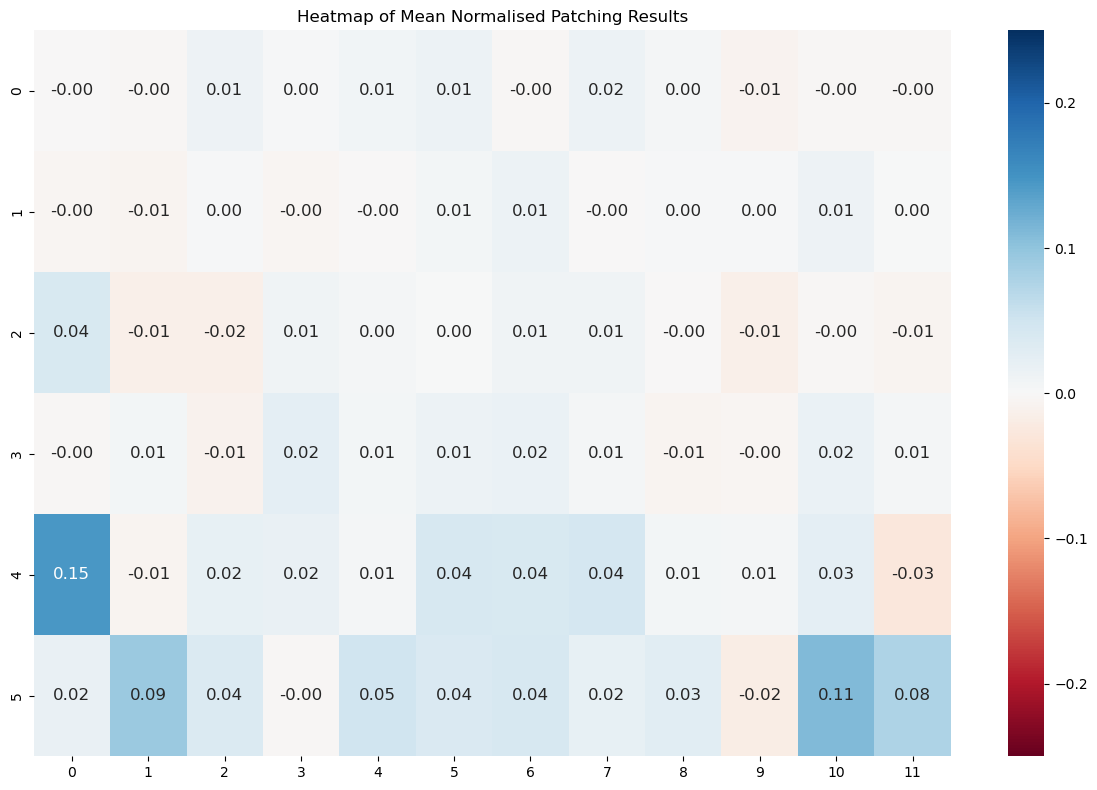

In [108]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[(all_data_pd['query'] == random_queries[2]) & (all_data_pd['injected_term'] == 'alteration')].index[2]
]

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

Let's test another query:

In [109]:
all_data_pd[all_data_pd['query'] == random_queries[3]]

,qid,query,docno,text,relevance,perturbed,perturbed_score,rank,original_score,score_delta,...,tfidf_injected_term,injected_term_token_len,patching_effect_std,patching_effect_absolute_mean,patching_effect_normalised_std,patching_effect_normalised_absolute_mean,patching_effect_normalised_square_std,patching_effect_normalised_square_absolute_mean,patching_effect_normalised_clip_std,patching_effect_normalised_clip_absolute_mean
57,183378,exons definition biology,1865221,A sequence of nucleotides found in the dna of ...,0,True,100.387650,62,87.706085,12.681564,...,0.000000,2,0.401269,0.244166,0.031642,0.019254,0.031544,0.019194,0.031642,0.019254
129,183378,exons definition biology,4490071,Many subprime mortgages had a low initial inte...,0,True,87.322823,811,76.674438,10.648384,...,0.000000,2,0.329594,0.198446,0.030952,0.018636,0.030817,0.018555,0.030952,0.018636
347,183378,exons definition biology,8168056,Use the portion of the genetic code given in t...,0,True,89.682030,736,81.028923,8.653107,...,0.000000,2,0.268908,0.152672,0.031076,0.017644,0.030871,0.017527,0.031076,0.017644
454,183378,exons definition biology,304958,Genes only make up about 1 percent of the DNA ...,0,True,89.221596,751,81.398407,7.823189,...,0.000000,2,0.244432,0.135461,0.031245,0.017315,0.030992,0.017176,0.031245,0.017315
552,183378,exons definition biology,217594,Borrowers with high credit scores tend to get ...,0,True,84.648056,862,77.451912,7.196144,...,0.000000,2,0.211132,0.124278,0.029340,0.017270,0.029060,0.017106,0.029340,0.017270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3877,183378,exons definition biology,4803847,"For other uses, see Exon (disambiguation) . An...",3,True,104.240822,17,104.074844,0.165977,...,0.092382,2,0.010416,0.008064,0.062754,0.048585,0.010275,0.007955,0.062754,0.048585
3941,183378,exons definition biology,1289490,ex·on. A portion of DNA that codes for a secti...,3,True,97.923256,146,97.439209,0.484047,...,0.000000,1,0.041411,0.031209,0.085551,0.064476,0.037274,0.028091,0.085551,0.064476
3947,183378,exons definition biology,749540,Frequently Asked Questions What is Exome Seque...,3,True,96.981537,186,96.809738,0.171799,...,0.206157,2,0.013434,0.009959,0.078195,0.057967,0.013240,0.009815,0.078195,0.057967
3963,183378,exons definition biology,4493916,Answer by Shelbyray2014. Confidence votes 91. ...,3,True,98.106743,138,98.020927,0.085815,...,0.660166,2,0.016228,0.011729,0.189108,0.136676,0.016169,0.011686,0.189108,0.136676


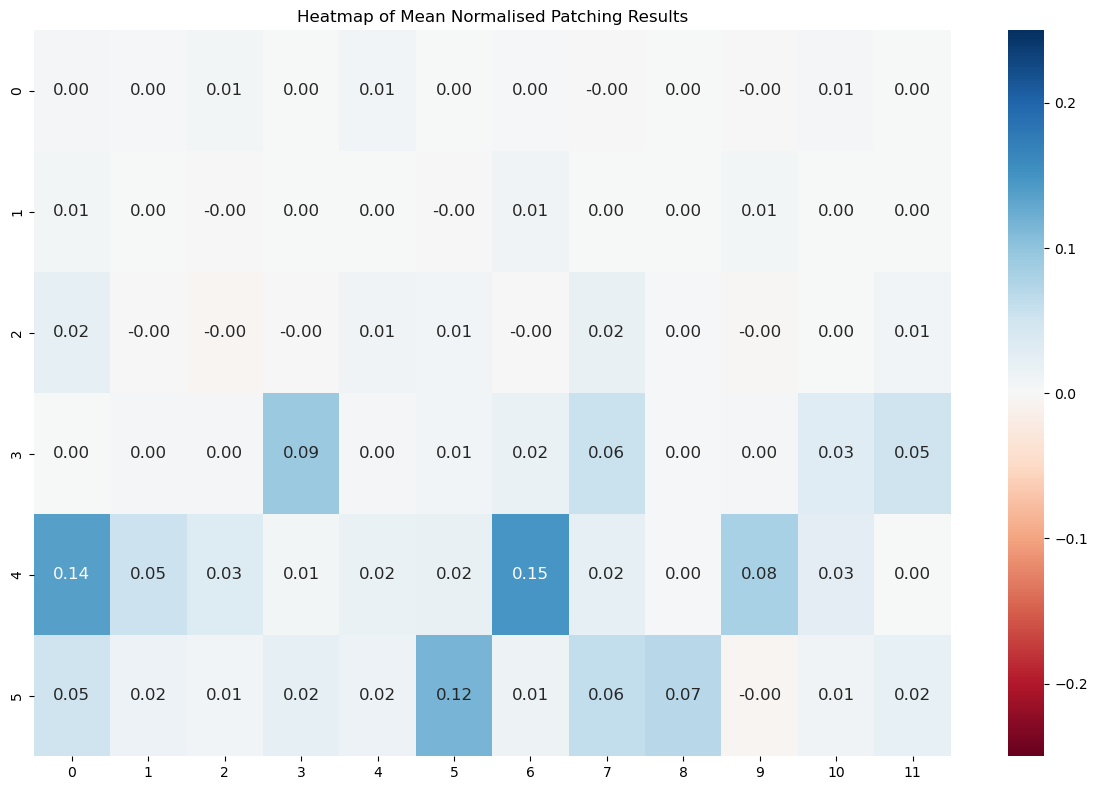

In [112]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[(all_data_pd['query'] == random_queries[3]) & (all_data_pd['injected_term'] == 'exons')].index[0]
]

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

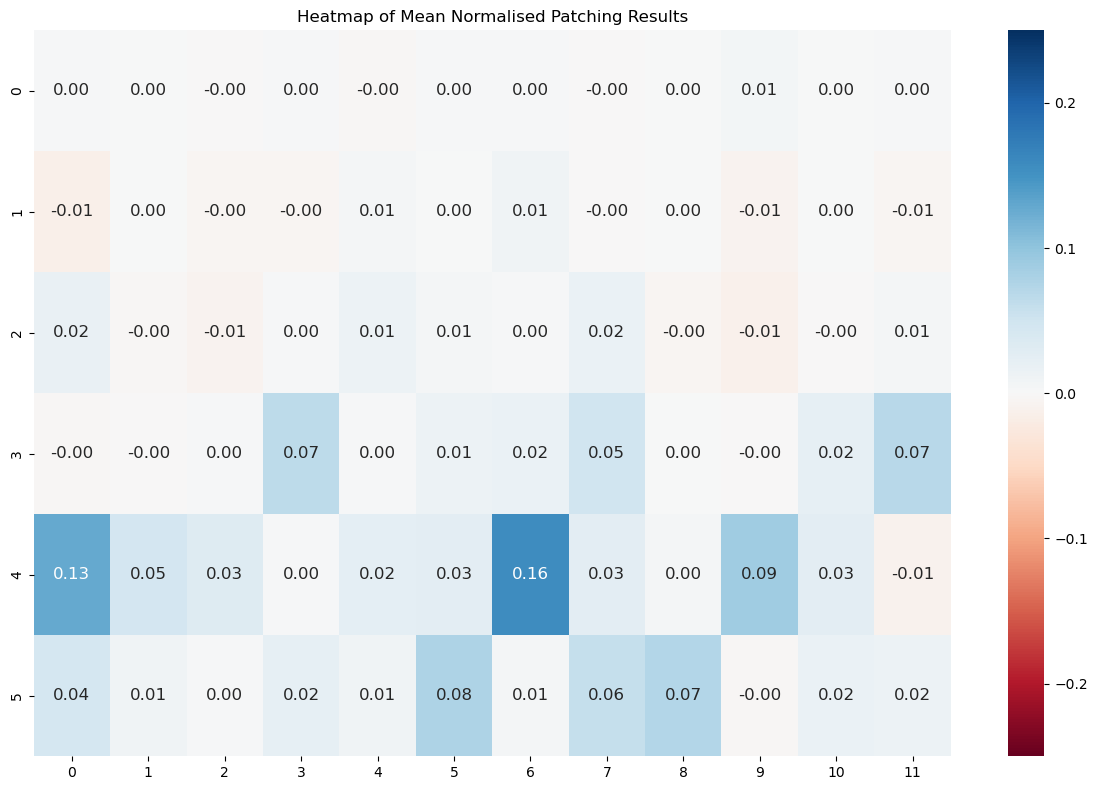

In [113]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[(all_data_pd['query'] == random_queries[3]) & (all_data_pd['injected_term'] == 'exons')].index[1]
]

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

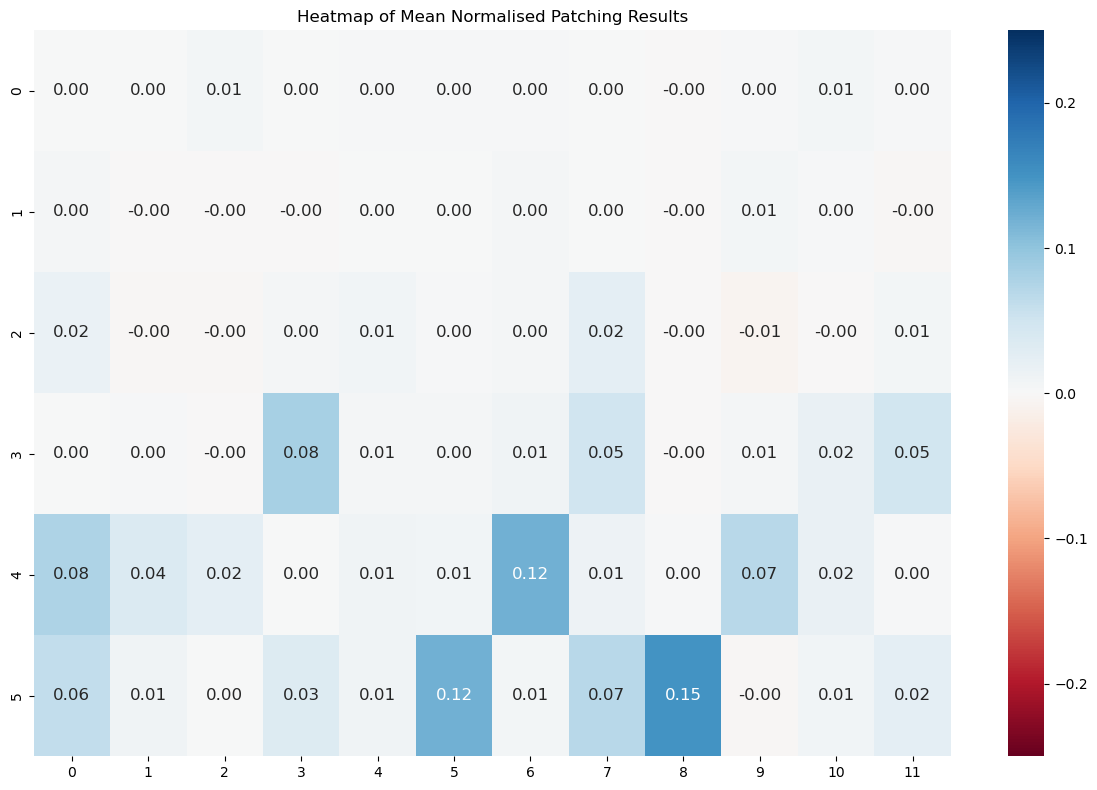

In [114]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[(all_data_pd['query'] == random_queries[3]) & (all_data_pd['injected_term'] == 'exons')].index[2]
]

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

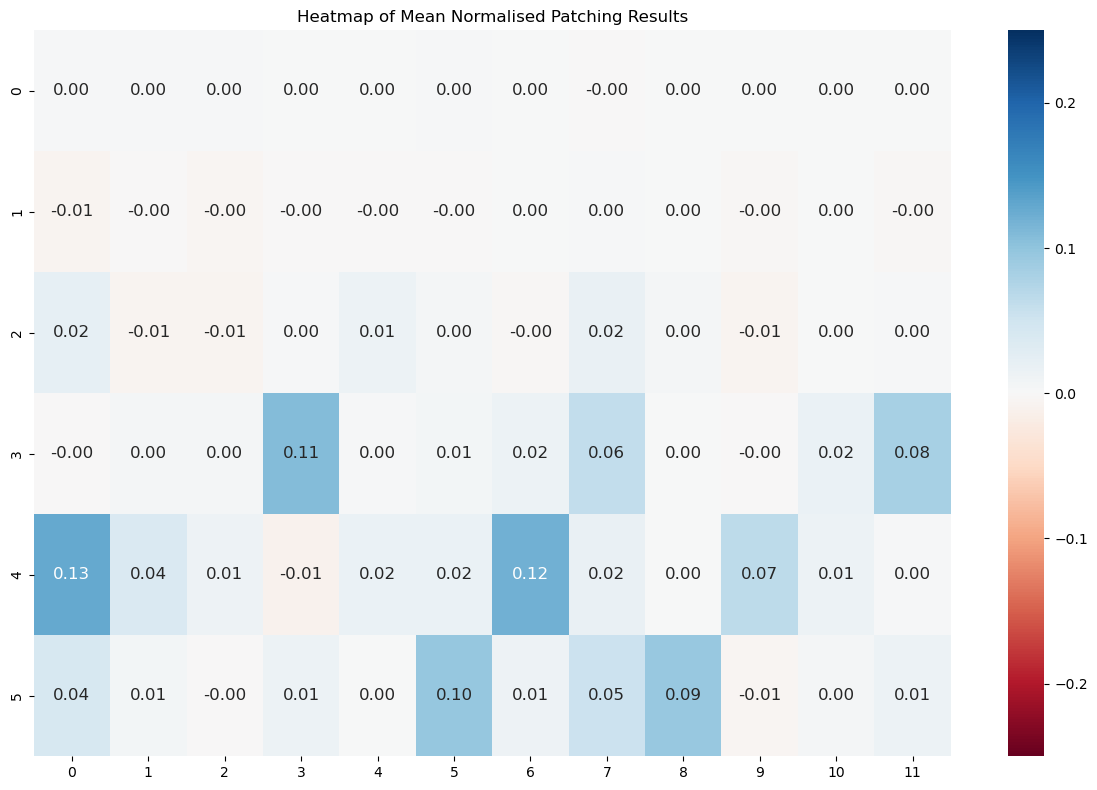

In [115]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[(all_data_pd['query'] == random_queries[3]) & (all_data_pd['injected_term'] == 'exons')].index[3]
]

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

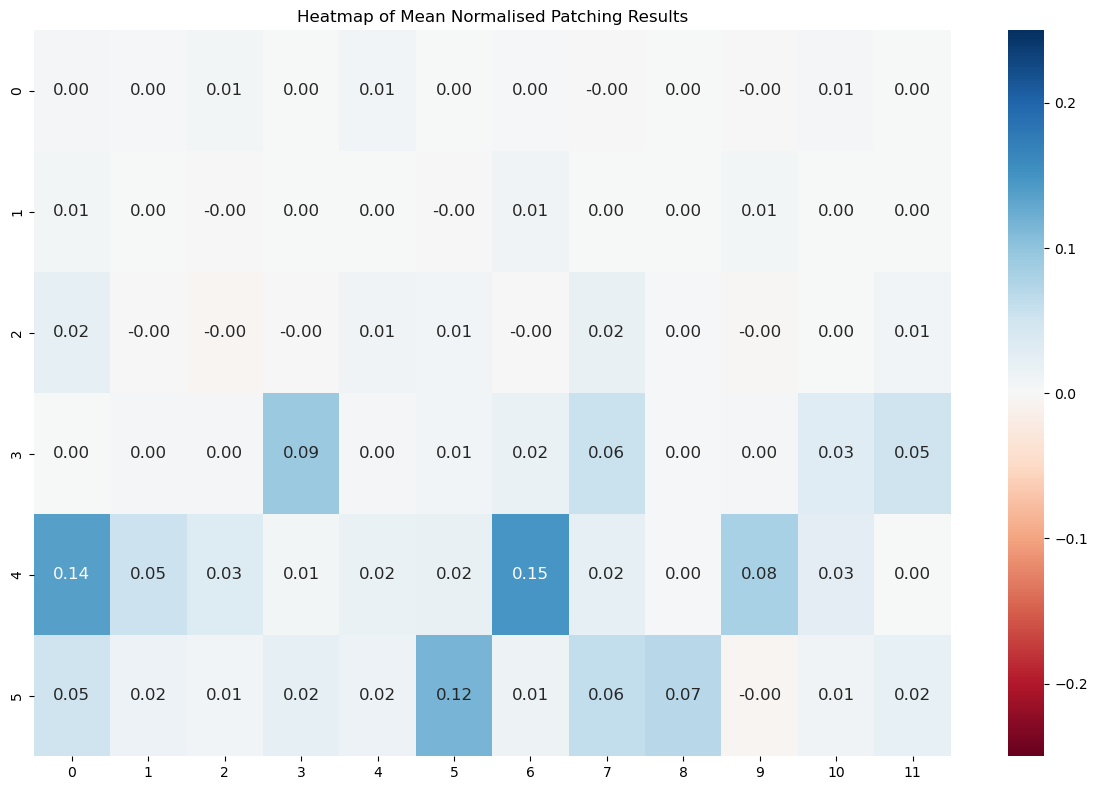

In [122]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[(all_data_pd['query'] == random_queries[3]) & (all_data_pd['injected_term'] == 'exons') & (all_data_pd['tf_injected_term'] == 0)].index[0]
]

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

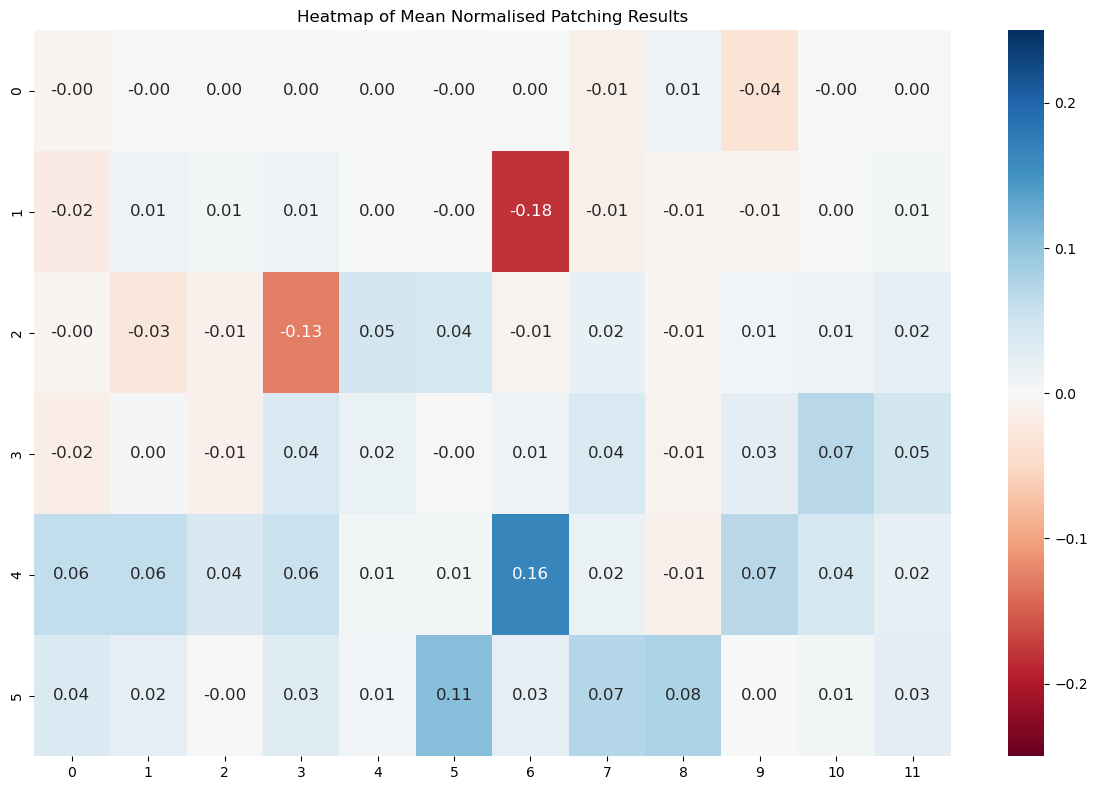

In [123]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[(all_data_pd['query'] == random_queries[3]) & (all_data_pd['injected_term'] == 'exons') & (all_data_pd['tf_injected_term'] == 1)].index[0]
]

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

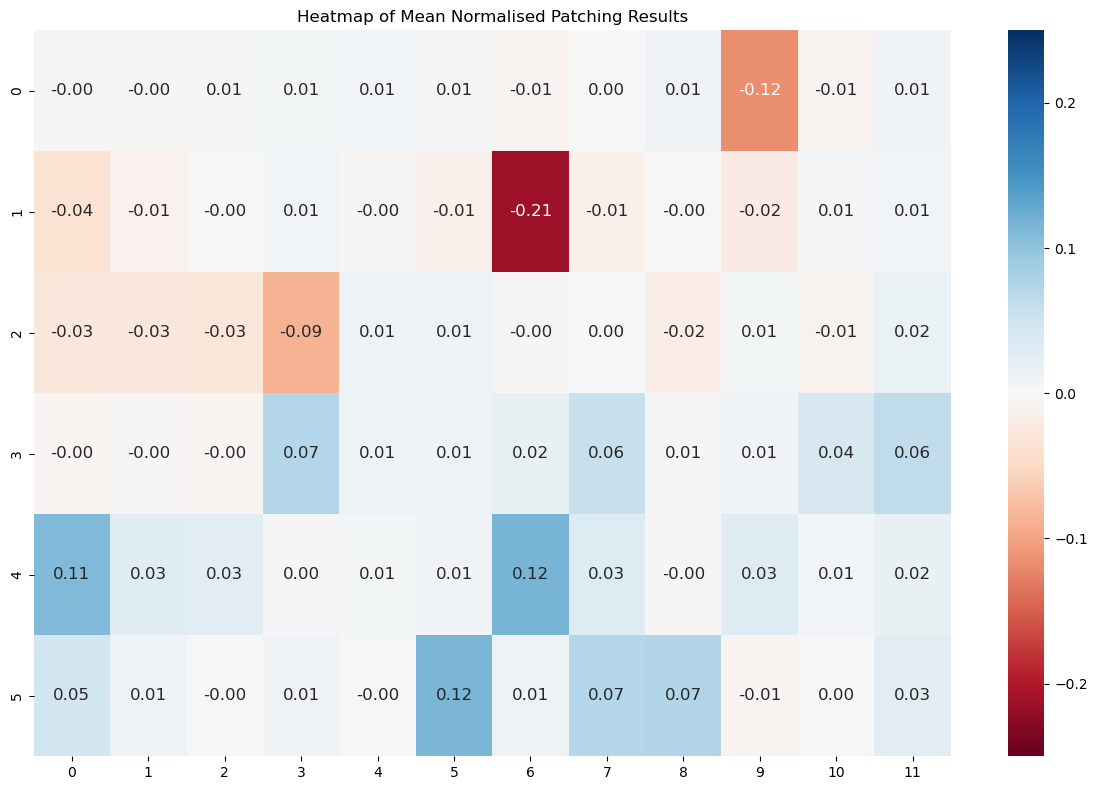

In [124]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[(all_data_pd['query'] == random_queries[3]) & (all_data_pd['injected_term'] == 'exons') & (all_data_pd['tf_injected_term'] == 2)].index[0]
]

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

In [133]:
all_data_pd[(all_data_pd['query'] == random_queries[3]) & (all_data_pd['injected_term'] == 'definition')]

,qid,query,docno,text,relevance,perturbed,perturbed_score,rank,original_score,score_delta,...,tfidf_injected_term,injected_term_token_len,patching_effect_std,patching_effect_absolute_mean,patching_effect_normalised_std,patching_effect_normalised_absolute_mean,patching_effect_normalised_square_std,patching_effect_normalised_square_absolute_mean,patching_effect_normalised_clip_std,patching_effect_normalised_clip_absolute_mean
1225,183378,exons definition biology,1678834,"Introns, Exons and Splicing hn RNA. 1 The seq...",1,True,98.223076,135,95.395889,2.827187,...,0.000000,1,0.137400,0.087137,0.048600,0.030821,0.045818,0.029057,0.048600,0.030821
1280,183378,exons definition biology,3389582,Exons and introns are part of the mRNA. During...,1,True,100.249725,66,97.720306,2.529419,...,0.000000,1,0.100372,0.069831,0.039682,0.027607,0.036902,0.025674,0.039682,0.027607
1297,183378,exons definition biology,1127571,The completed human sequence can now identify ...,1,True,90.179085,688,87.889595,2.289490,...,0.000000,1,0.100920,0.059171,0.044080,0.025845,0.040395,0.023684,0.044080,0.025845
1804,183378,exons definition biology,3377749,Yes. A protein produced by multiple genes are ...,1,True,92.063751,563,91.066826,0.996925,...,0.000000,1,0.041197,0.028097,0.041325,0.028184,0.029176,0.019898,0.041325,0.028184
3087,183378,exons definition biology,8794307,Home » Executor » Exercise bone » Exhibitions ...,3,True,99.684631,85,97.217445,2.467186,...,0.000000,1,0.108928,0.070916,0.044151,0.028744,0.040917,0.026639,0.044151,0.028744
3519,183378,exons definition biology,8794308,"By definition, exons and introns are sequences...",3,True,103.075844,22,102.540703,0.535141,...,0.076357,1,0.025852,0.019522,0.048308,0.036481,0.022793,0.017213,0.048308,0.036481
3527,183378,exons definition biology,8577215,Exon definition may facilitate splice site sel...,3,True,100.133133,71,99.561081,0.572052,...,0.095936,1,0.059227,0.036812,0.103534,0.064352,0.051409,0.031954,0.103534,0.064352
3758,183378,exons definition biology,5391354,This exon definition process determines the se...,3,True,98.652092,121,98.375999,0.276093,...,0.085034,1,0.044442,0.028700,0.160969,0.103949,0.042840,0.027665,0.160969,0.103949


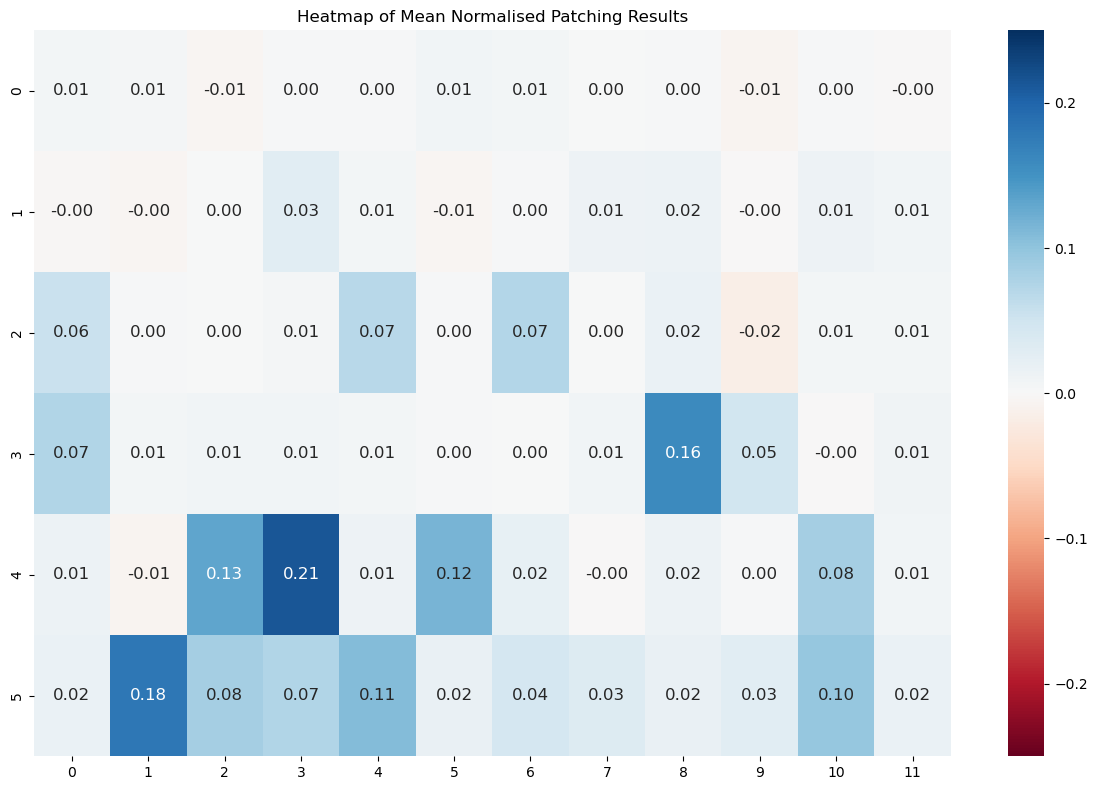

In [134]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[(all_data_pd['query'] == random_queries[3]) & (all_data_pd['injected_term'] == 'definition') & (all_data_pd['tf_injected_term'] == 0)].index[0]
]

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

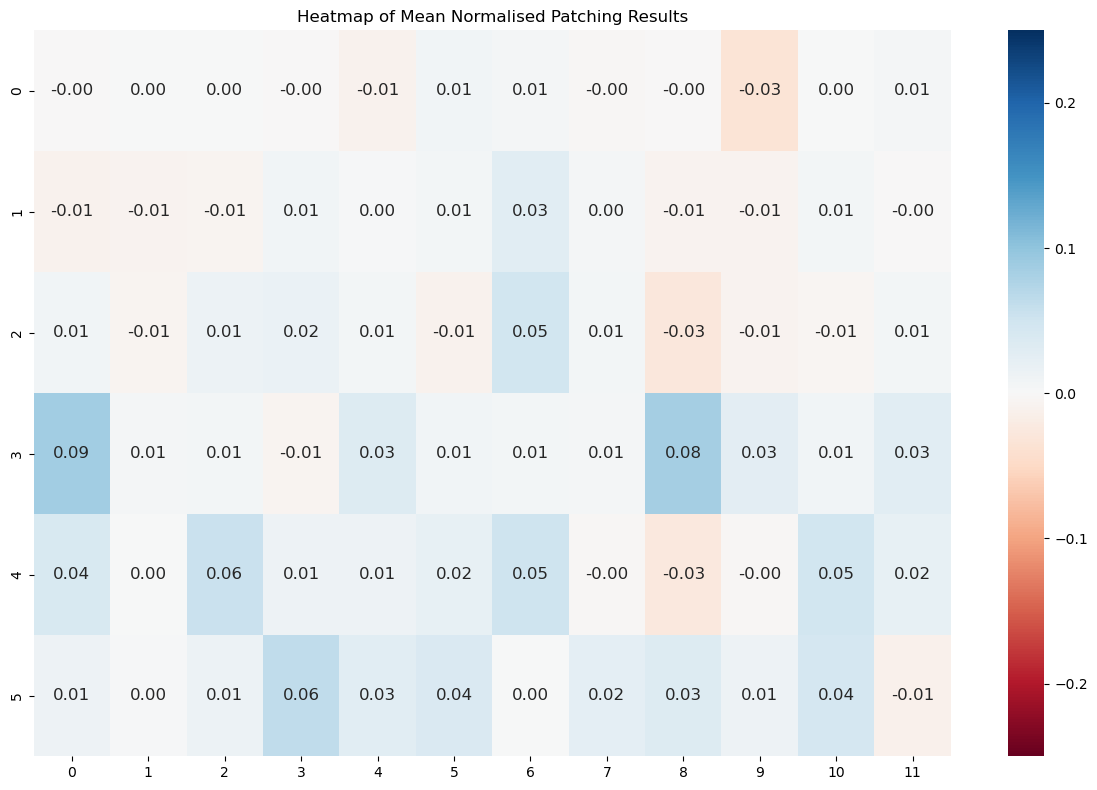

In [135]:
data_to_plot = patching_results_normalised_square[
    all_data_pd[(all_data_pd['query'] == random_queries[3]) & (all_data_pd['injected_term'] == 'definition') & (all_data_pd['tf_injected_term'] == 1)].index[0]
]

plot(data_to_plot, 0.25, -0.25, "Mean Normalised Patching Results (Top 1000 by Score Difference)")

Let's take another query: